## Plots from the shake-table database

This jupyter notebook contains all the plots presented in the data paper "A database of shake-table tests conducted on unreinforced masonry buildings"

Manuscript submitted to Earthquake Spectra

Authors: Mathias Haindl, Katrin Beyer, and Ian F. C. Smith

Created on: 05.07.2023

Last update: 05.11.2023

### Import all the required packages for post-processing the data

In [176]:
# Import packages required to read and post-process the information in the database
# note: requires urllib3 2+
import urllib3
import pandas as pd
import numpy as np
import math
import seaborn as sns
import textwrap
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from collections import Counter
from fractions import Fraction
import plotly.graph_objects as go

http = urllib3.PoolManager()
#base_url = "http://127.0.0.1:8000"
base_url = "https://mast-dev.epfl.ch/api"

In [177]:
import warnings
warnings.filterwarnings("ignore", message="All-NaN axis encountered")

### Definition of functions for post-processing data
We define some functions for post-processing and plotting purposes

In [178]:
# Function to wrap text in case it exist and overlapping (specially in x-lables)
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


In [179]:
# Function to count the number of values in each range for a given group
def count_values_in_range(group):
    counts = np.histogram(group, bins=ranges)[0]
    return pd.Series(counts, index=ranges[1:])


In [180]:
# Function to derive fragility functions
from scipy.optimize import minimize_scalar
import statsmodels.api as sm

def probit_function(IM, p_exceed):
    """
    Fits a lognormal CDF to observed probability of collapse data using Probit regression.
    
    Inputs:
    IM: numpy array, IM levels of interest
    num_gms: int or numpy array, number of ground motions used at each IM level
    num_collapse: numpy array, number of collapses observed at each IM level
    
    Outputs:
    theta: float, median of fragility function
    beta: float, lognormal standard deviation of fragility function
    """

    # Reshape vectors into column vectors
    IM = IM.reshape((-1, 1))
    p_exceed = np.array(p_exceed)
    p_exceed = p_exceed.reshape((-1, 1))

    # Probit regression
    X = np.log(IM)
    X = sm.add_constant(X)
    Y = p_exceed
    
    model = sm.GLM(Y, X, family=sm.families.Binomial(sm.families.links.Probit()))
    result = model.fit()

    b = result.params
    
    # Convert probit coefficients to lognormal distribution parameters
    theta = np.exp(-b[0] / b[1])
    beta = 1 / b[1]
    
    return b, theta, beta


### Set common plotting parameters

In [181]:
# Set parameters for plotting
plt.rcParams['font.family'] = 'Arial'
w_val = 0.7         #value for the default width for the bars in the bar plots
plt_font = 18       #fontsize for ticks in the plots
lgd_font = 16       #fontsize for legend in the plots
txt_font = 16       #fontsize for text embedded in the plots
axisLabel_font = 22 #fontsize for axis labels


### Load database and prepare data

In [182]:
# Experiment summaries
resp = http.request("GET", f"{base_url}/experiments/")

# works only with most recent urllib3 version
#experiments = pd.DataFrame(resp.json())
import json
experiments = pd.DataFrame(json.loads(resp.data.decode('utf-8')))


In [183]:
# Generate classes of materials (clay, stone, calcium silicate, concrete, and adobe)
stone_types = ['calcareous','sandstone','limestone','granite','tuff']
def stone_type(x):
    for stone_type in stone_types:
        if stone_type.casefold() in x.casefold():
            return 'Stone'
    if 'mortar' in x.casefold():
        return 'Concrete'
    return x
experiments["masonry_unit_material_class"] = experiments["masonry_unit_material"].apply(stone_type)

In [184]:
experiments["retrofitting_application_new"] = experiments["retrofitting_application"].apply(lambda x: "Not retrofitted" if x == "Not present" else x)

In [185]:
# Generate DataFrame for failure mechanisms observed in each individual building
crack_types = set()
for x in experiments["crack_types_observed"].to_list():
    if x != None:
      crack_types.update(x)
crack_types
fail_mech = pd.DataFrame(columns=list(crack_types))
for col in fail_mech.columns:
    fail_mech[col] = experiments["crack_types_observed"].map(lambda x: "Yes" if x != None and col in x else "No")

In [186]:
# Experiment run results
resp = http.request("GET", f"{base_url}/run_results")
#results = pd.DataFrame(resp.json())
results = pd.DataFrame(json.loads(resp.data.decode('utf-8')))
run_results = results.loc[results["run_id"].apply(lambda x: x != "Initial" and x != "Final")]
run_t_results = results[["run_id", "reported_t1_x", "reported_t1_y", "experiment_id"]]

In [187]:
# filter run_t_results for both "reported_t1_x" and "reported_t1_y" being not nan, only when run_id is Initial or Final
run_t_results = run_t_results[(~run_t_results["run_id"].isin(["Initial", "Final"])) | (run_t_results["reported_t1_x"].notna()) | (run_t_results["reported_t1_y"].notna())]

## Plots in the paper
### Figure 1a - Statistics on material and type of masonry units

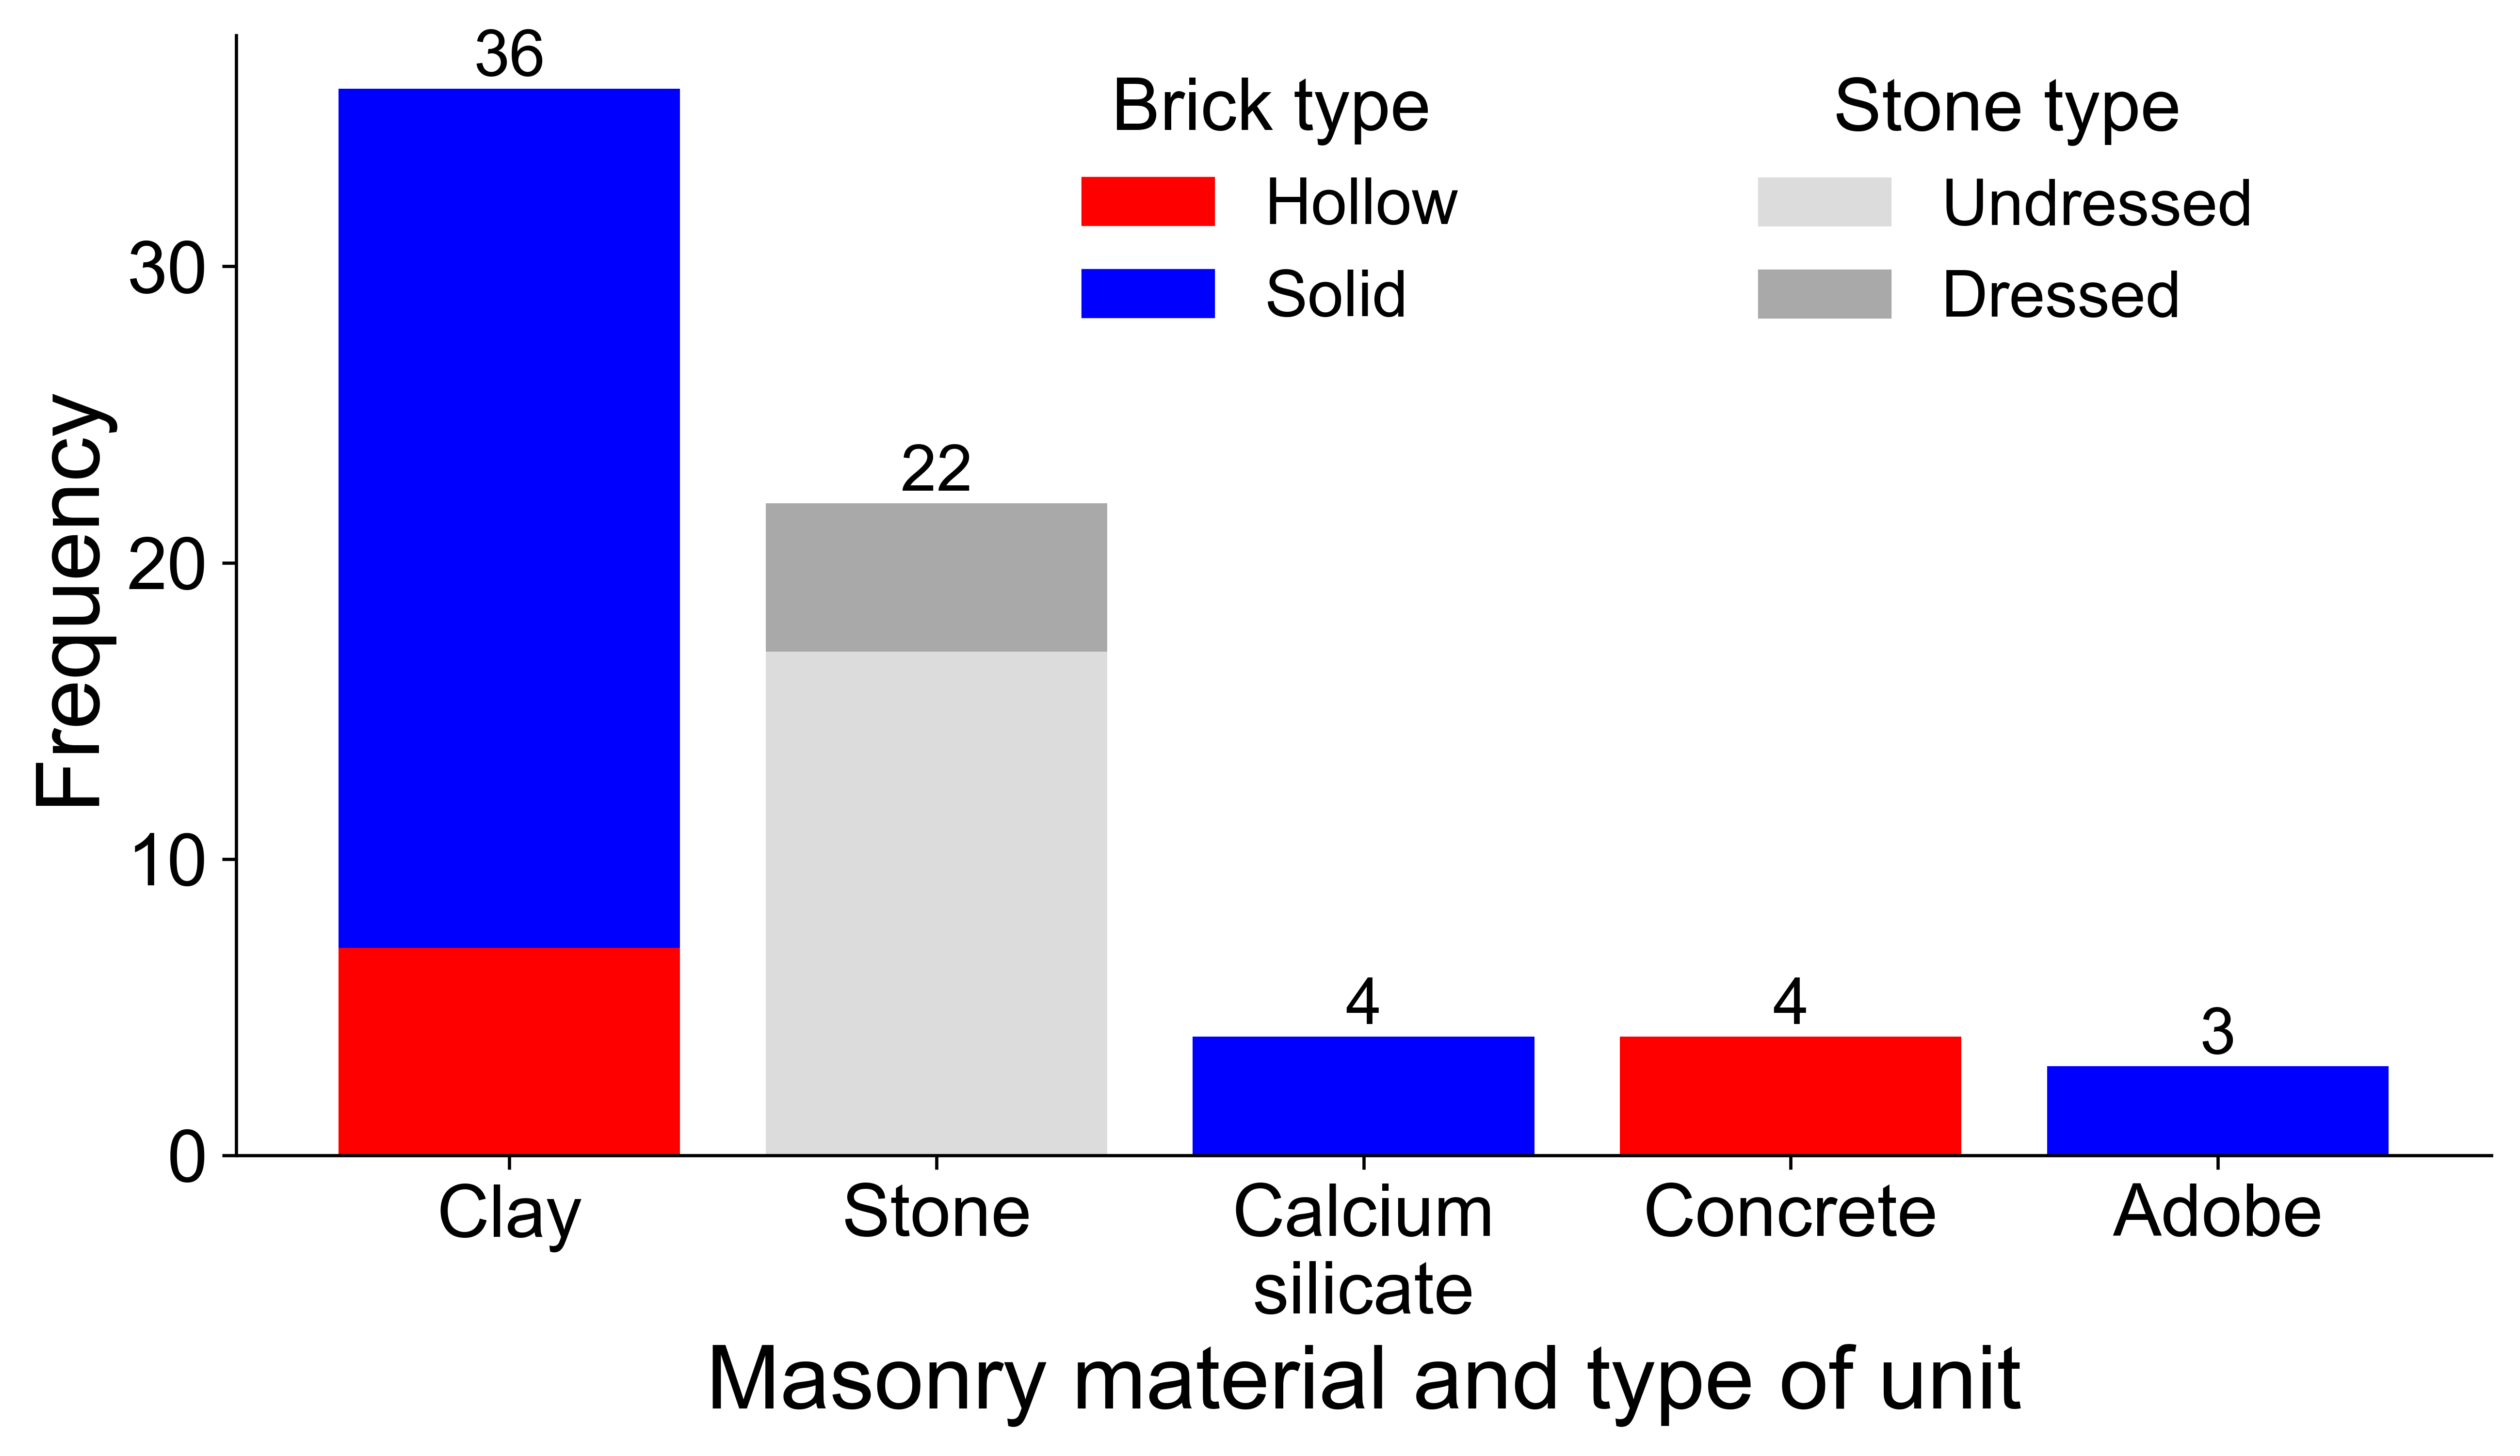

In [188]:
## Figure 1a: Bar plot stacked for material and type of masonry units

# Get variables for masonry type and material
B_num = np.array(experiments["id"])
mas_type = np.array(experiments["masonry_unit_type"])
mas_mat = np.array(experiments["masonry_unit_material"])
mas_mat_class = np.array(experiments["masonry_unit_material_class"])
        
# Process data for masonry material and type
_uA1, varA1 = np.unique(mas_type, return_inverse=True)
_uA2, varA2 = np.unique(mas_mat_class, return_inverse=True)
rep_varA1 = np.bincount(varA1)
rep_varA2 = np.bincount(varA2)
XpA1 = np.array(varA1)
XpA2 = np.array(varA2)

pairs = list(zip(mas_type, mas_mat_class))
pair_counts = Counter(pairs)
labels, values = zip(*pair_counts.items())

# Grouping pairs by second parameter
stacked_pairs = {}
stacked_pairs_type = {}
for pair, count in pair_counts.items():
    key = pair[1]  # Get the second parameter of the pair
    ktype = pair[0]
    if key in stacked_pairs:
        stacked_pairs[key].append((pair, count))
    else:
        stacked_pairs[key] = [(pair, count)]
    if ktype in stacked_pairs_type:
        stacked_pairs_type[ktype].append((pair, count))
    else:
        stacked_pairs_type[ktype] = [(pair, count)] 

# Extracting labels, counts, and colors from stacked pairs
labels = list(stacked_pairs.keys())
labels_type = list(stacked_pairs_type.keys())
counts = [[count for _, count in pairs] for pairs in stacked_pairs.values()]
colors = ['red', 'blue', 'gainsboro', 'darkgrey', 'dimgrey']        

# Plotting the stacked bar plot
plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)

for i in range(0,len(counts)):
    for j in range(0,len(counts[i])):
        if 'hollow' in list(stacked_pairs.items())[i][1][j][0][0].casefold():
            colorf = colors[0]
            pl1 = plt.bar(labels[i], counts[i][j], bottom=sum(counts[i][:j]), color=colorf)
        if 'solid' in list(stacked_pairs.items())[i][1][j][0][0].casefold():
            colorf = colors[1]
            pl2 = plt.bar(labels[i], counts[i][j], bottom=sum(counts[i][:j]), color=colorf)
        if 'undressed' in list(stacked_pairs.items())[i][1][j][0][0].casefold():
            colorf = colors[2]
            pl3 = plt.bar(labels[i], counts[i][j], bottom=sum(counts[i][:j]), color=colorf)
        if 'dressed' in list(stacked_pairs.items())[i][1][j][0][0].casefold() and 'undressed' not in list(stacked_pairs.items())[i][1][j][0][0].casefold():
            colorf = colors[3]
            pl4 = plt.bar(labels[i], counts[i][j], bottom=sum(counts[i][:j]), color=colorf)

leg1 = plt.legend((pl1,pl2),['Hollow', 'Solid'], ncol=1, bbox_to_anchor=(0.35, 0.85), loc='center left', frameon=False, title='Brick type', fontsize=lgd_font)
plt.gca().add_artist(leg1)
leg2 = plt.legend((pl3,pl4),['Undressed','Dressed'], ncol=1, bbox_to_anchor=(0.65, 0.85), loc='center left', frameon=False,title='Stone type', fontsize=lgd_font)

leg1.legend_handles[0].set_color(colors[0])
leg1.legend_handles[1].set_color(colors[1])
leg2.legend_handles[0].set_color(colors[2])
leg2.legend_handles[1].set_color(colors[3])
        
for i in range(0,len(labels)):
    freq=sum(counts[i])
    plt.text(labels[i], freq, f'{freq:.0f}', horizontalalignment='center', verticalalignment='bottom', fontsize=txt_font)
        
# Displaying the plot
plt.xlabel('Masonry material and type of unit', fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.xticks(np.unique(XpA2),labels)
ax = plt.gca()
wrap_labels(ax, 10)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 1b - Statistics on diaphragm material

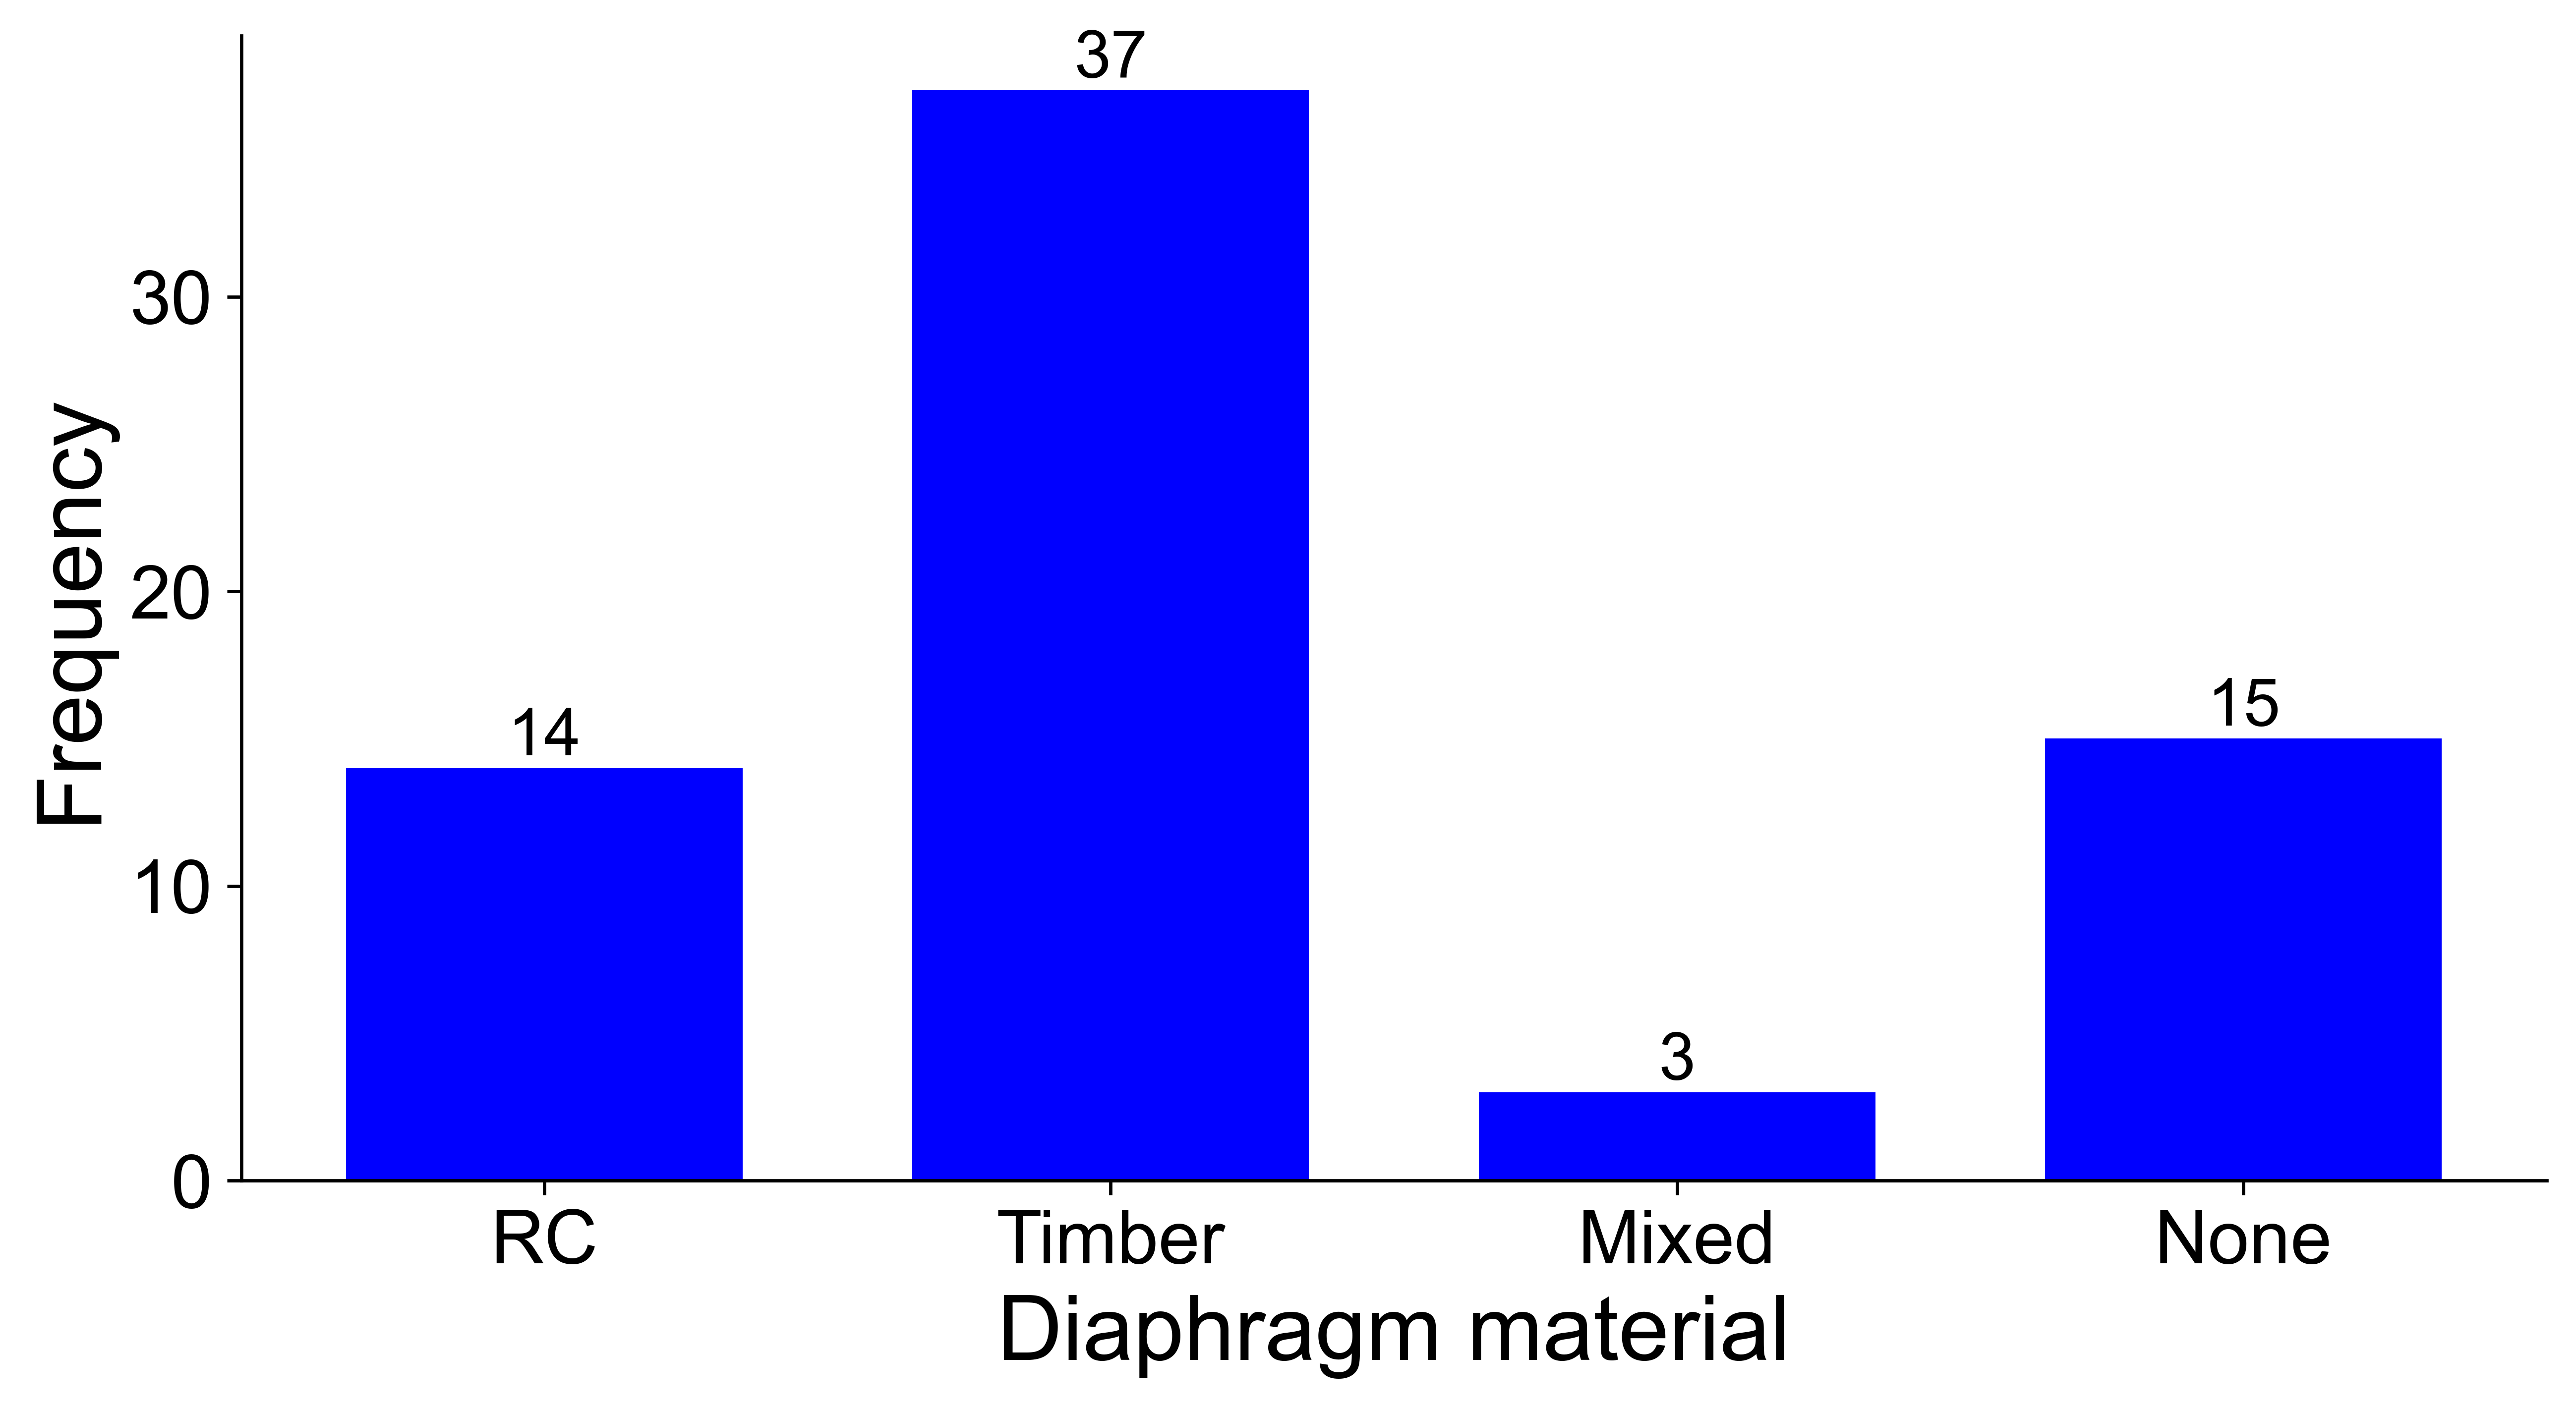

In [189]:
## Figure 1b: Bar plot stacked for diaphragm material

# Get variables for the material of the diaphragms
diaph_mat = experiments["diaphragm_material"]

# Convert the array to a list, replace np.nan with 'n/a', and then convert it back to a NumPy array
diaph_mat_list = diaph_mat.tolist()
diaph_mat_list = ['n/a' if isinstance(item, float) and np.isnan(item) else item for item in diaph_mat_list]
diaph_mat = np.array(diaph_mat_list, dtype=str)

# Generate classes of diaphragm according to the main material
diaph_mat_new = diaph_mat.copy()
for i in range(0, len(diaph_mat_new)):
    if 'timber & steel' in diaph_mat[i].casefold():
        diaph_mat_new[i] = 'Mixed'
    if 'steel & bricks' in diaph_mat[i].casefold():
        diaph_mat_new[i] = 'Mixed'
    if 'timber & concrete' in diaph_mat[i].casefold():
        diaph_mat_new[i] = 'Mixed'
    if 'rc & timber' in diaph_mat[i].casefold():
        diaph_mat_new[i] = 'Mixed'    
    if 'hollow tile' in diaph_mat[i].casefold():
        diaph_mat_new[i] = 'Mixed'
    if 'jack-arch' in diaph_mat[i].casefold():
        diaph_mat_new[i] = 'Mixed'
    if 'n/a' in diaph_mat[i].casefold():
        diaph_mat_new[i] = 'N/A'
        
# Process data for material of diaphragms  
_uB, varB = np.unique(diaph_mat_new, return_inverse=True)
rep_varB = np.bincount(varB)
XpB = np.array(varB)

indexes = np.unique(diaph_mat_new, return_index=True)[1]
_uB = [diaph_mat_new[index] for index in sorted(indexes)]

#Reassign the total number of tests for each masonry unit material (forced coded)
for i in range(0,len(diaph_mat_new)):
    if diaph_mat_new[i] == _uB[0]:
        varB[i] = 0
    if diaph_mat_new[i] == _uB[1]:
        varB[i] = 1
    if diaph_mat_new[i] == _uB[2]:
        varB[i] = 2
    if diaph_mat_new[i] == _uB[3]:
        varB[i] = 3
        
rep_varB = np.bincount(varB)
XpB = np.array(varB)

# Plot figure
plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)
plt.bar(np.unique(XpB), rep_varB, color='b', width = w_val)

for i in range(len(rep_varB)):
    plt.text(np.unique(XpB)[i], rep_varB[i], f'{rep_varB[i]:.0f}',
             horizontalalignment='center',
             verticalalignment='bottom', fontsize=txt_font)

plt.xlabel("Diaphragm material", fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.xticks(np.unique(XpB),_uB)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 1c - Statistics on number of wall leaves and thickness

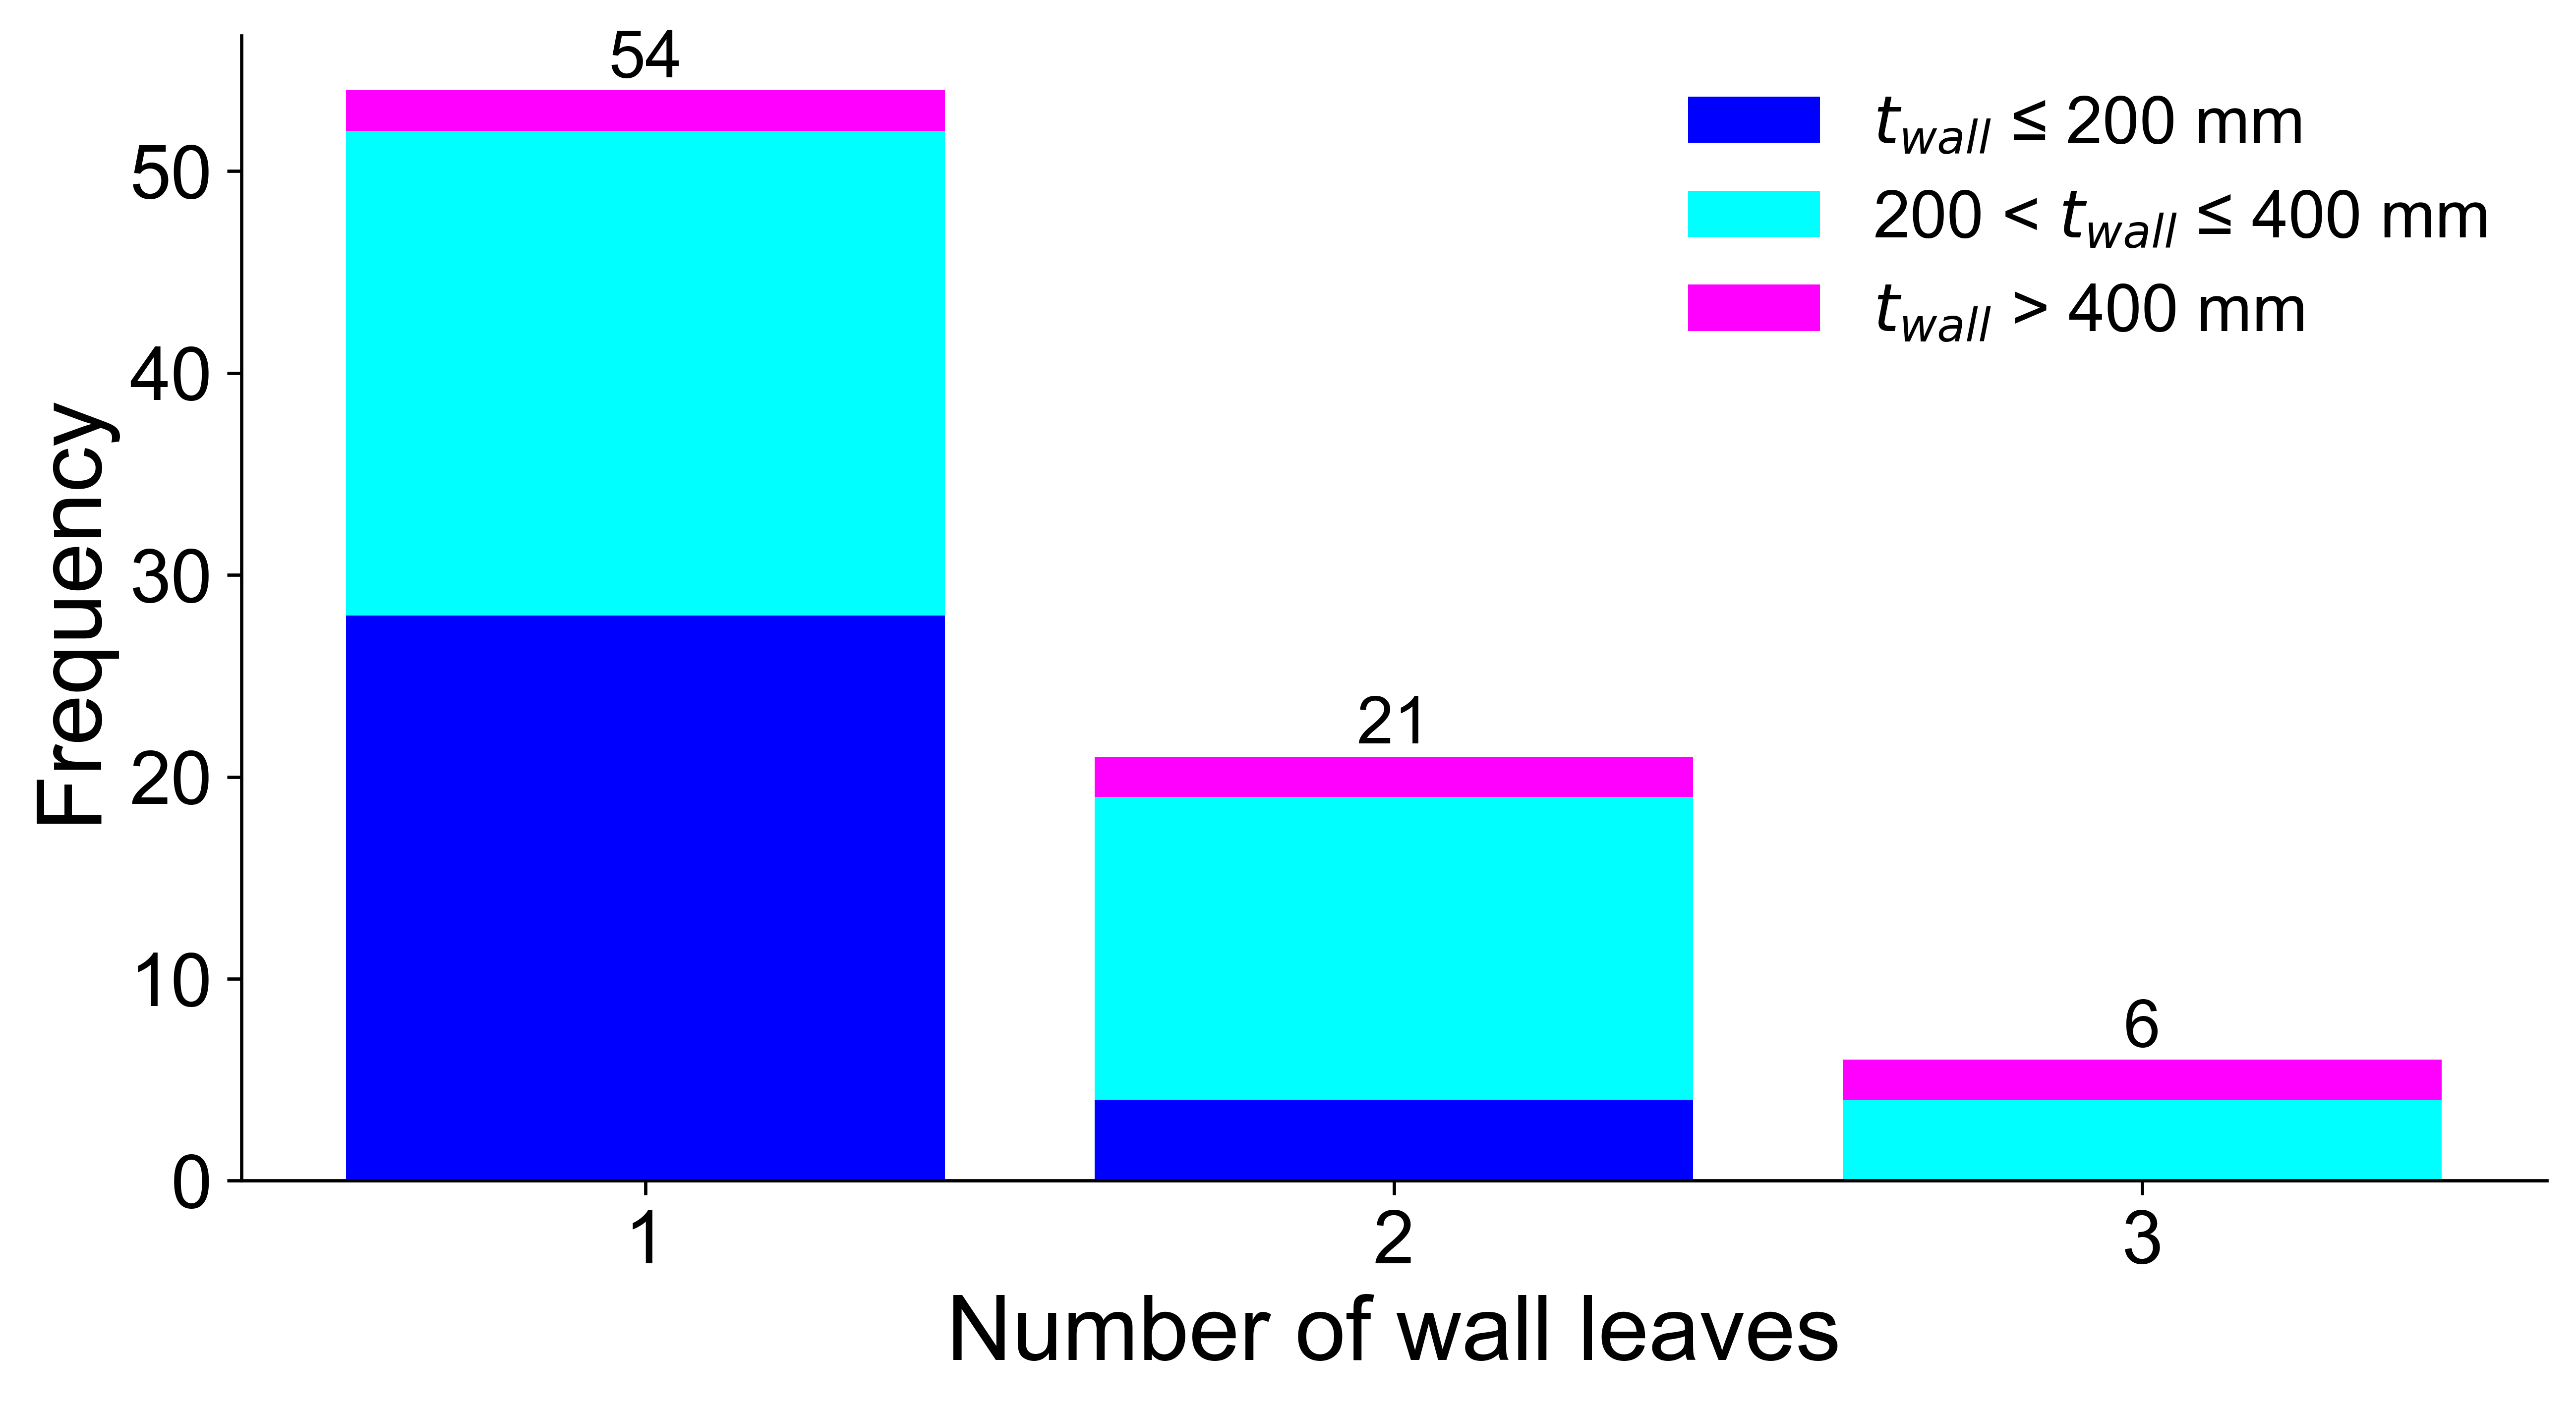

In [190]:
## Figure 1c: Bar plot stacked for the wall thickness and number of wall leaves

# Get variables for the thickness of walls
wall_thick = np.array(experiments["masonry_wall_thickness"].map(lambda x: "/".join(map(str, x)))) # Convert the int arrays to joined string arrays

# Get variables for the number of wall leaves
n_leaves = np.array(experiments["wall_leaves_nb"])

# Process data for number of wall leaves 
_uC2, varC2 = np.unique(n_leaves, return_inverse=True)
tick_labels = _uC2
   
# Convert the array of arrays to a numeric array
numeric_xpC = np.hstack(n_leaves)
xpC = wall_thick

# Separate numbers with slash (/) in between and expand the num_array
expanded_num_array = []
for num, val in zip(xpC, numeric_xpC):
    if '/' in num:
        split_values = num.split('/')
        expanded_num_array.extend([val] * len(split_values))
    else:
        expanded_num_array.append(val)

# Separate numbers with slash (/) in between
separated_numbers = []
for number in xpC:
    if '/' in number:
        separated_numbers.extend(number.split('/'))
    else:
        separated_numbers.append(number)

# Convert the list of expanded values to a NumPy array
expanded_XpC = np.array(expanded_num_array)
_exp_uC, exp_varC = np.unique(expanded_XpC, return_inverse=True)
rep_exp_varC = np.bincount(exp_varC)

# Convert all numbers to a numeric array
xpC = np.array([float(num) for num in separated_numbers])

# Create a pandas DataFrame with array_1 and array_2
df = pd.DataFrame({'expanded_XpC': expanded_XpC, 'xpC': xpC})

# Define the ranges ]0, 200], ]200, 400], and >400
ranges = [0, 200, 400, np.inf]

# Group by array_1 and count the values in each range for each group
grouped_counts = df.groupby('expanded_XpC')['xpC'].apply(count_values_in_range).unstack(fill_value=0)

# Create the stacked bar plot
x = grouped_counts.index
labels = ['$t_{wall}$ ≤ 200 mm', '200 < $t_{wall}$ ≤ 400 mm', '$t_{wall}$ > 400 mm']
colors = ['blue', 'cyan', 'magenta']

plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)

bottom = np.zeros(len(x))
for i in range(len(labels)):
    plt.bar(x, grouped_counts.iloc[:, i], bottom=bottom, color=colors[i], label=labels[i])
    bottom += grouped_counts.iloc[:, i]
    
for i in range(len(rep_exp_varC)):
    plt.text(np.unique(expanded_XpC)[i], rep_exp_varC[i], f'{rep_exp_varC[i]:.0f}',
             horizontalalignment='center',
             verticalalignment='bottom', fontsize=txt_font)    

plt.xlabel("Number of wall leaves", fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.legend(loc='upper right',frameon=False, fontsize=lgd_font)
plt.xticks(np.unique(expanded_XpC),_exp_uC)
ax = plt.gca()
ax.set_xticklabels(tick_labels.astype(int))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 1d - Statistics on the presence of internal walls

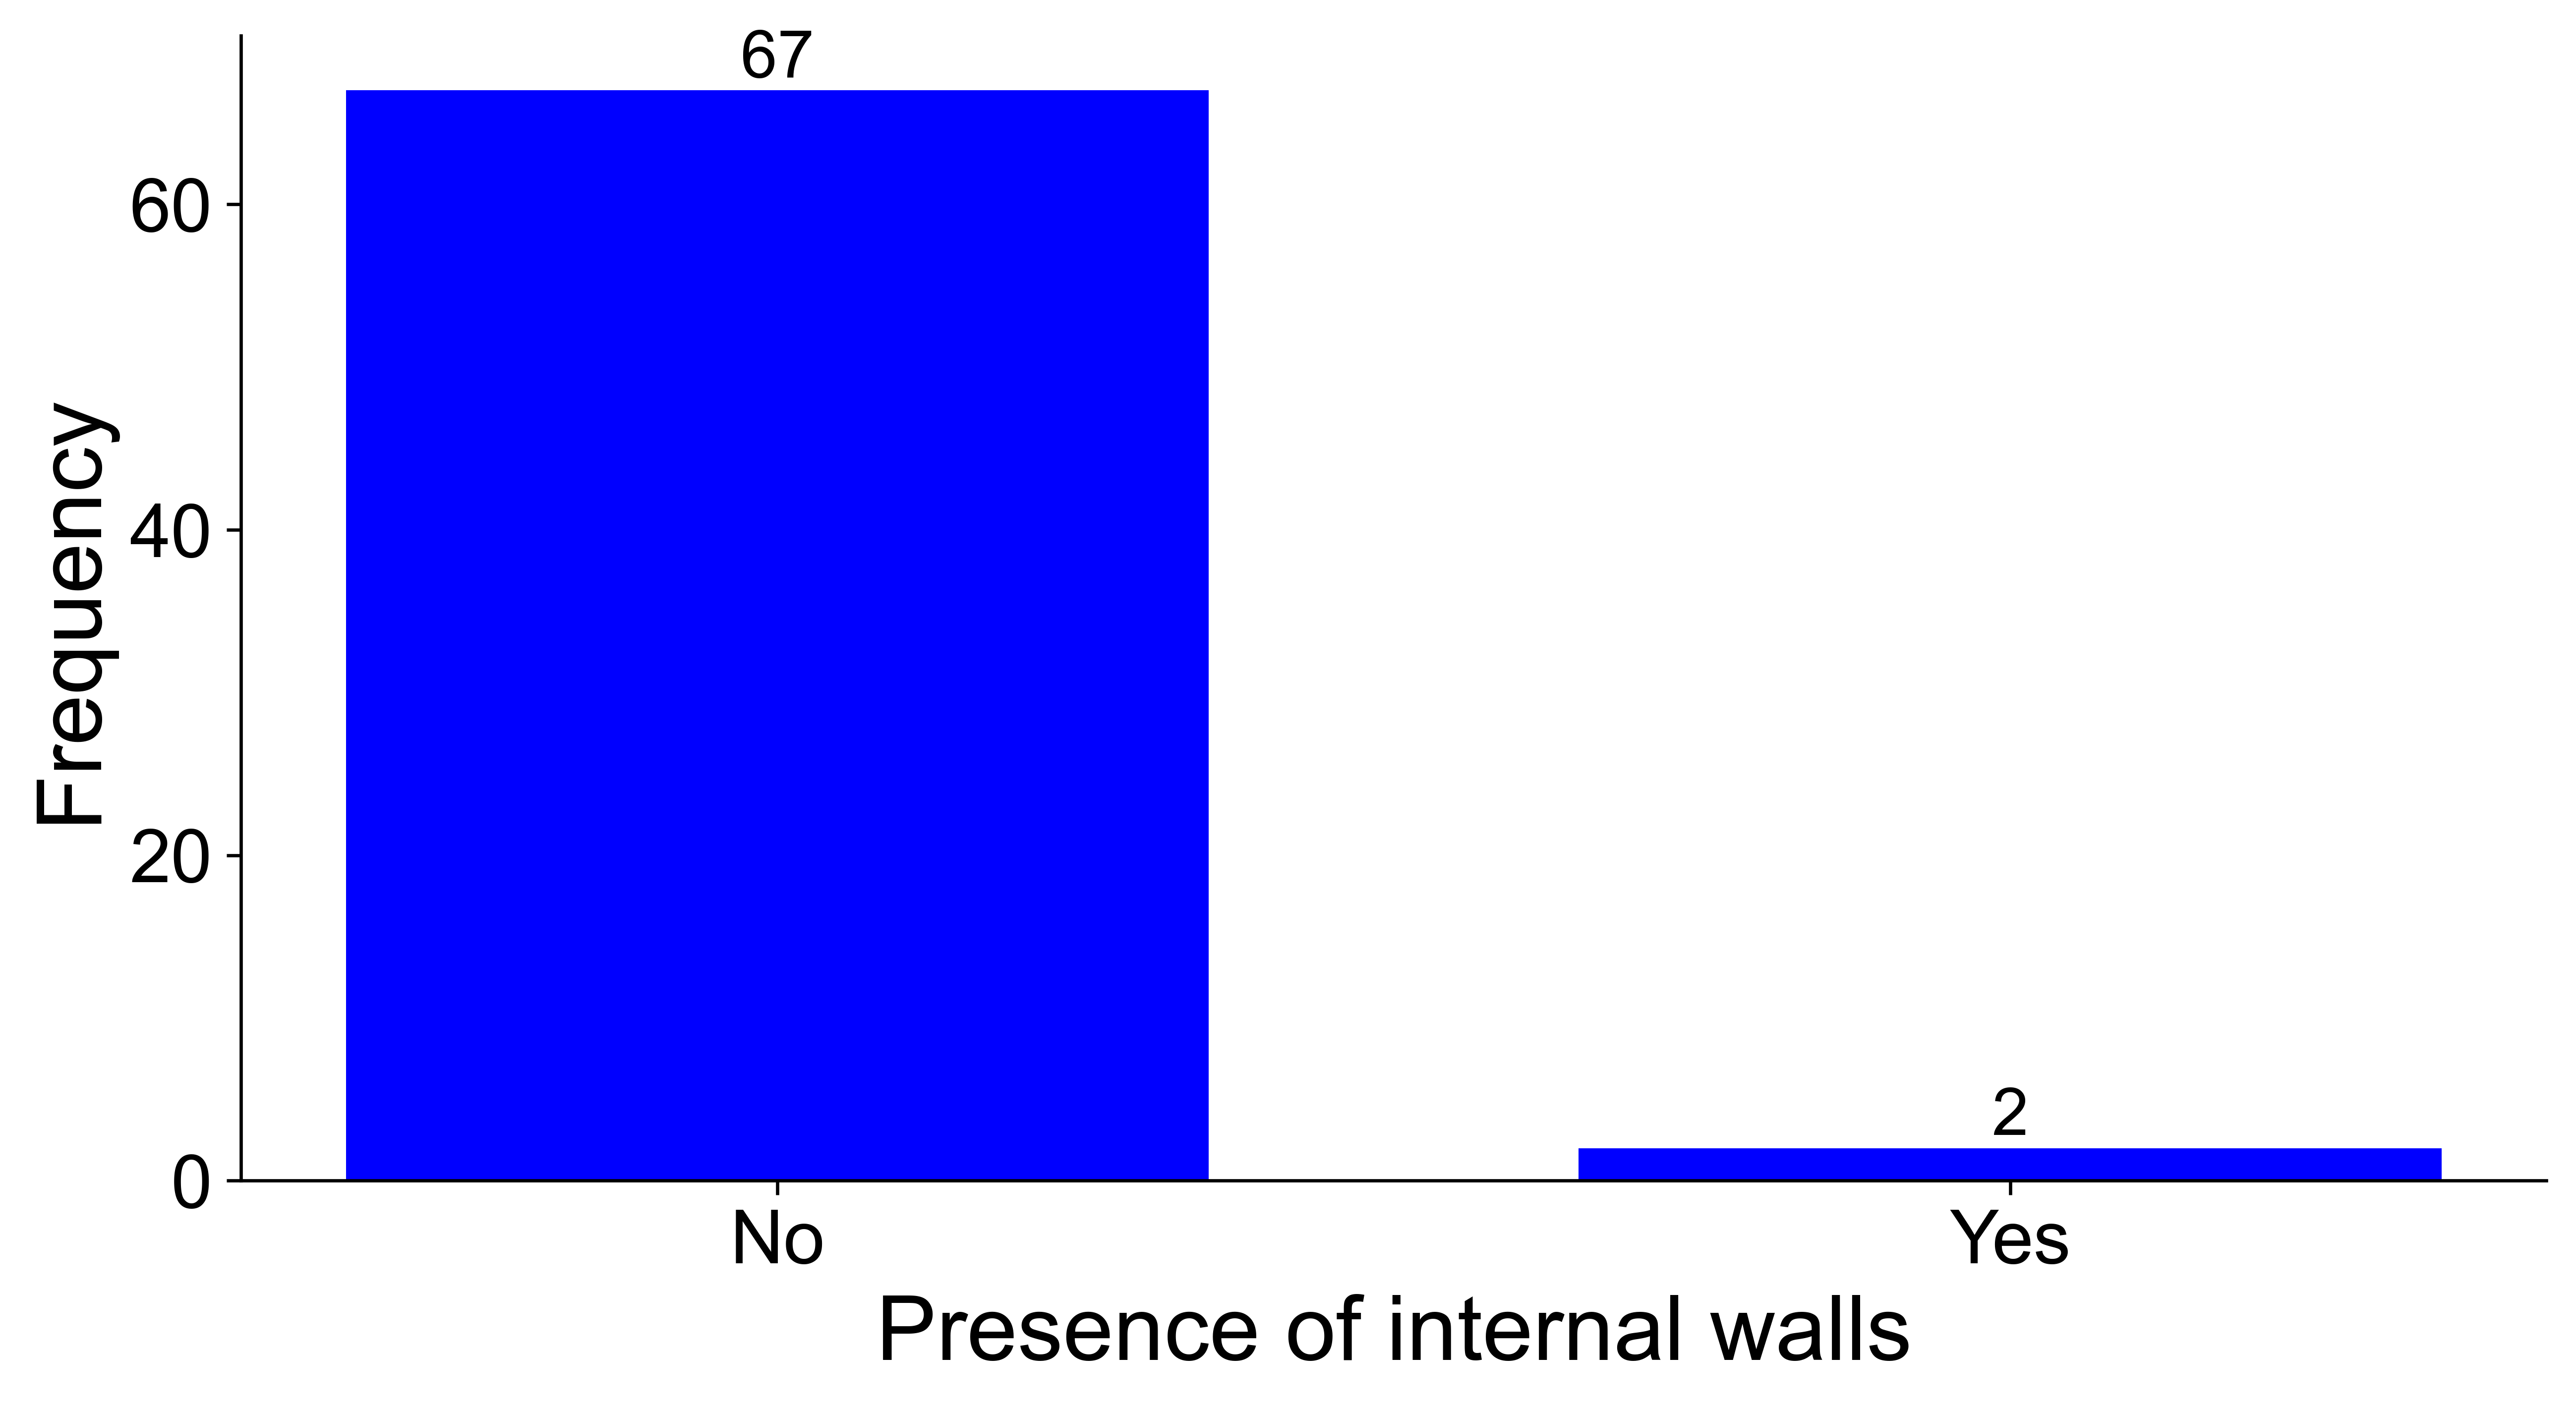

In [191]:
## Figure 1d: Bar plot for the presence of internal walls

# Get variables for the presence of internal walls
int_walls = np.array(experiments["internal_walls"].map(lambda x: "Yes" if x else "No"))
 
# Process data for internal walls
_uD, varD = np.unique(int_walls, return_inverse=True)
rep_varD = np.bincount(varD)
XpD = np.array(varD)
tick_labels = _uD

# Plot figure
plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)
plt.bar(np.unique(XpD), rep_varD, color='b', width = w_val)

for i in range(len(rep_varD)):
    plt.text(np.unique(XpD)[i], rep_varD[i], f'{rep_varD[i]:.0f}',
             horizontalalignment='center',
             verticalalignment='bottom', fontsize=txt_font)

plt.xlabel('Presence of internal walls', fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.xticks(np.unique(XpD),_uD)
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 1e - Statistics on number of storeys

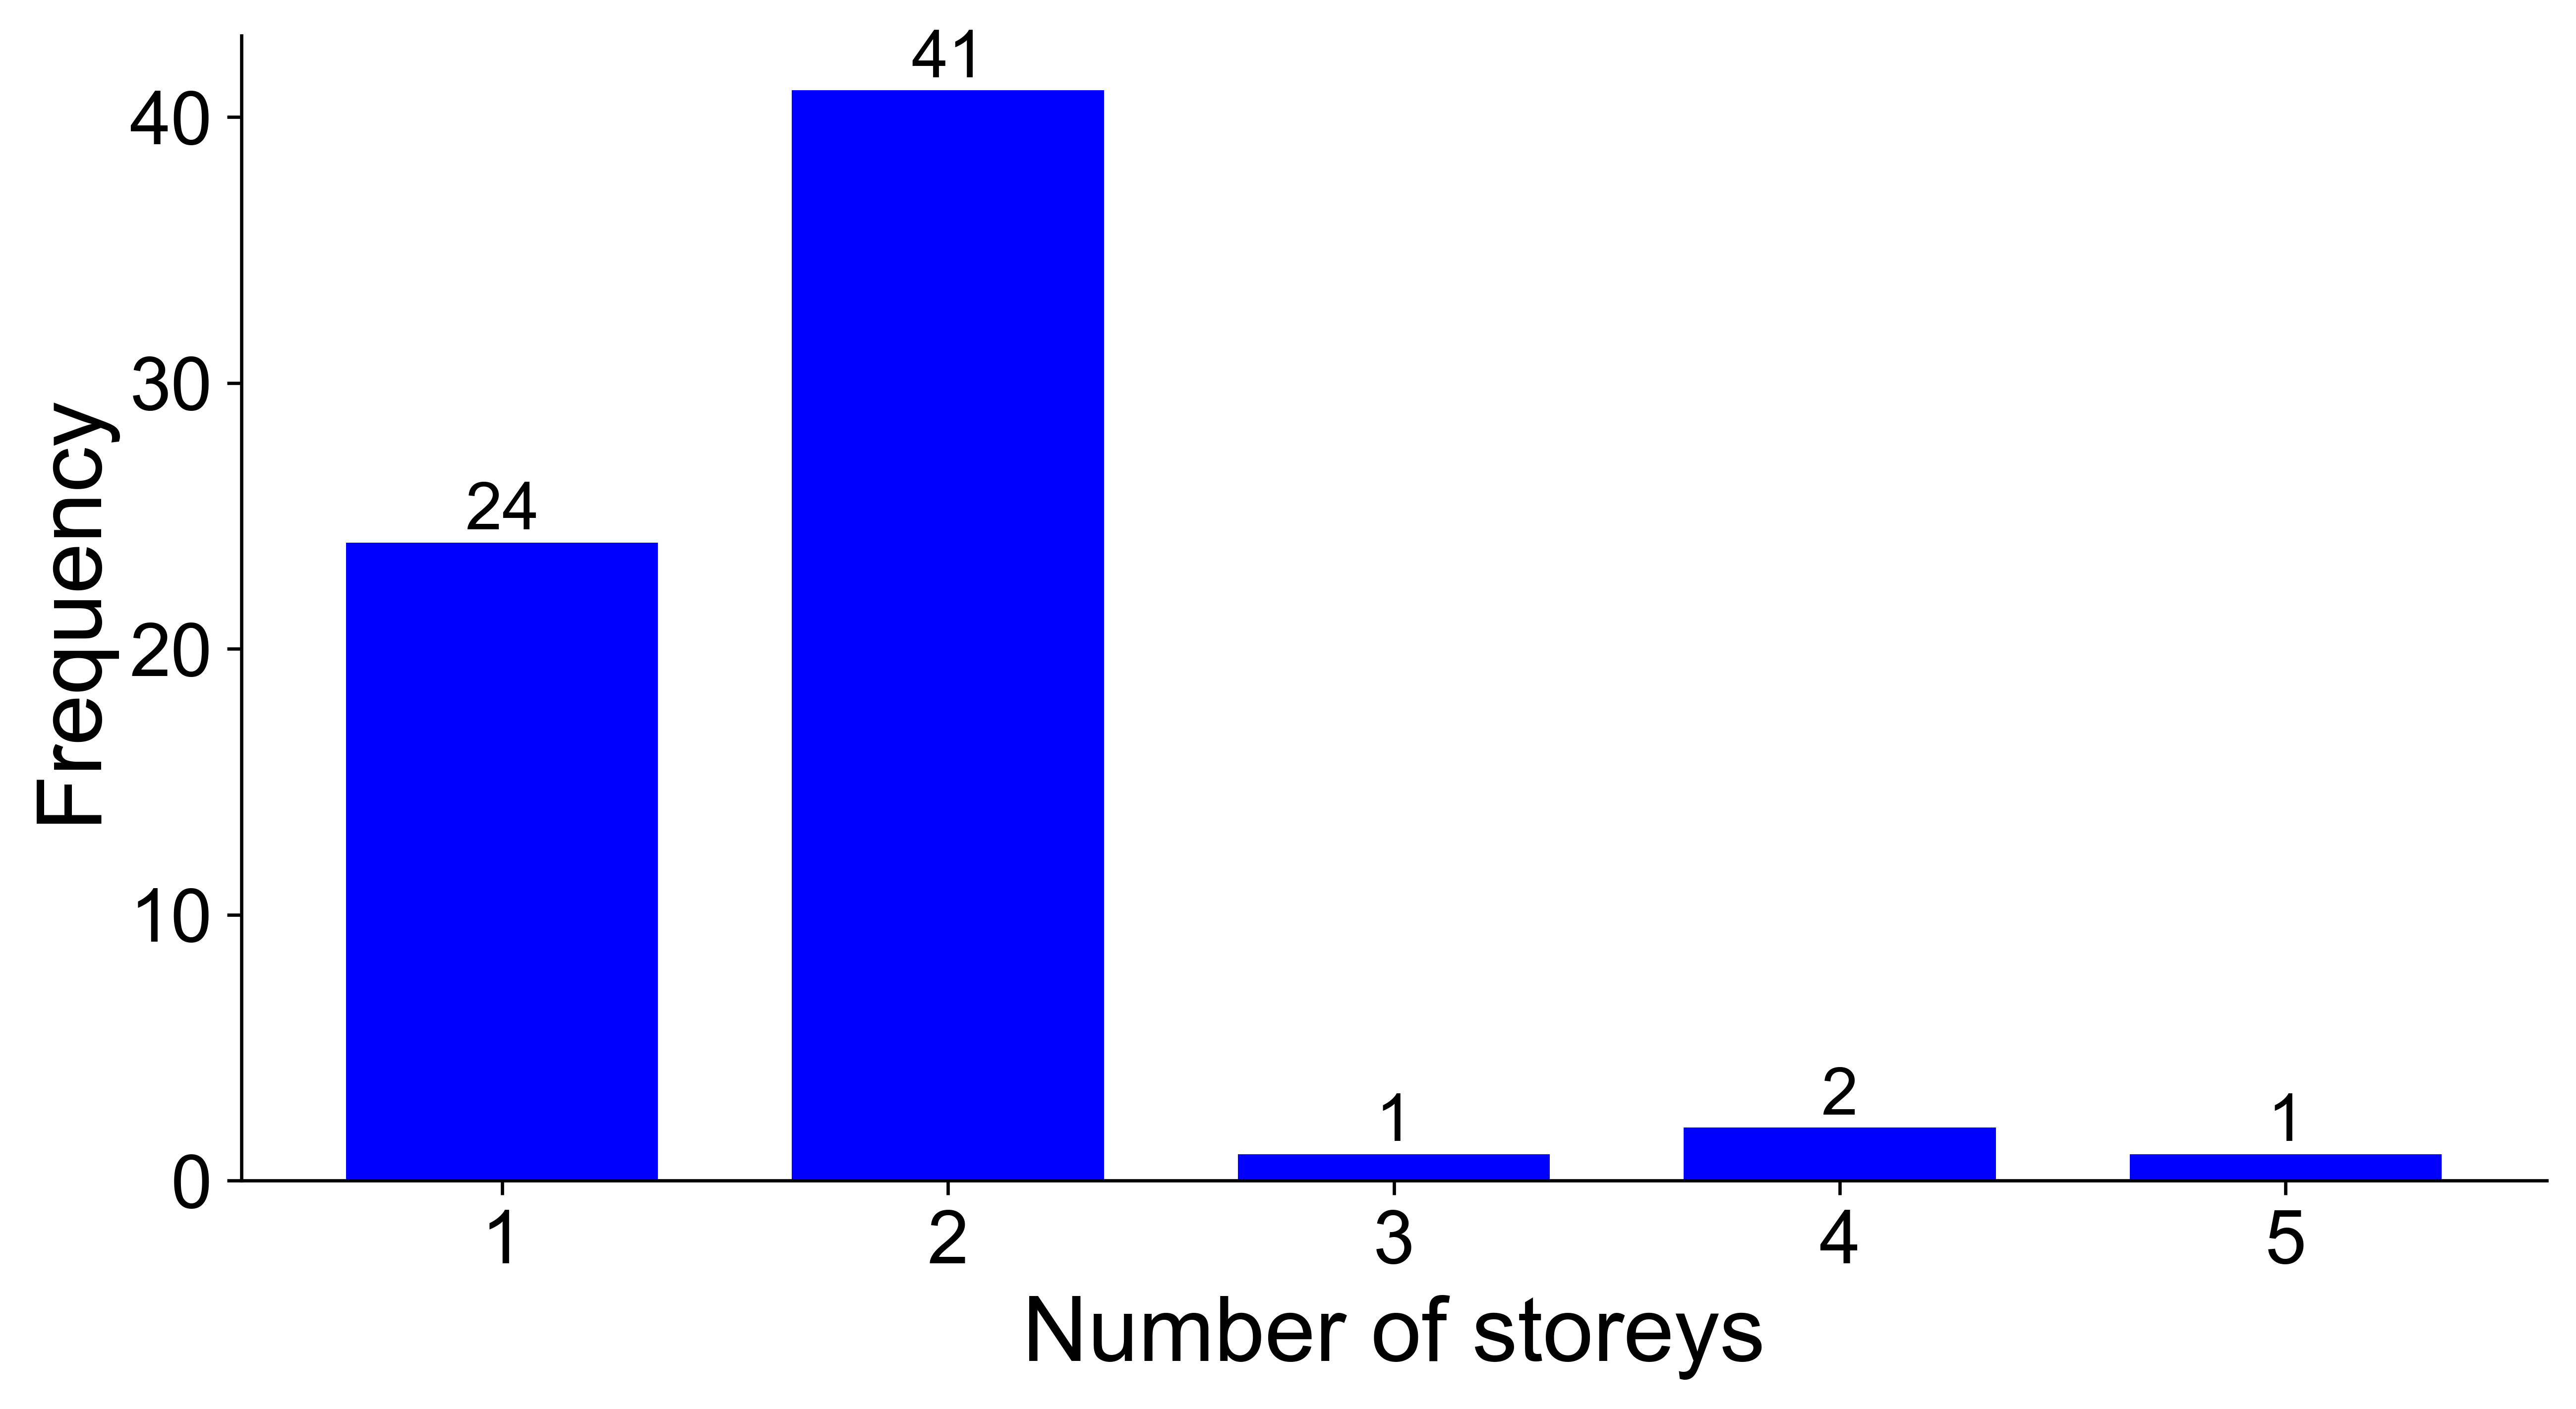

In [192]:
## Figure 1e: Bar plot for the number of storeys

# Get variables for the number of storeys
n_storeys = np.array(experiments["storeys_nb"])

# Process data for the number of storeys 
_uE, varE = np.unique(n_storeys, return_inverse=True)
rep_varE = np.bincount(varE)
XpE = np.array(varE)
tick_labels = _uE

# Plot figure
plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)
plt.bar(np.unique(XpE), rep_varE, color='b', width = w_val)

for i in range(len(rep_varE)):
    plt.text(np.unique(XpE)[i], rep_varE[i], f'{rep_varE[i]:.0f}',
             horizontalalignment='center',
             verticalalignment='bottom', fontsize=txt_font)

plt.xlabel("Number of storeys", fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.xticks(np.unique(XpE),_uE)
ax = plt.gca()
ax.set_xticklabels(tick_labels.astype(int))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 1f - Statistics on the scale of the tests

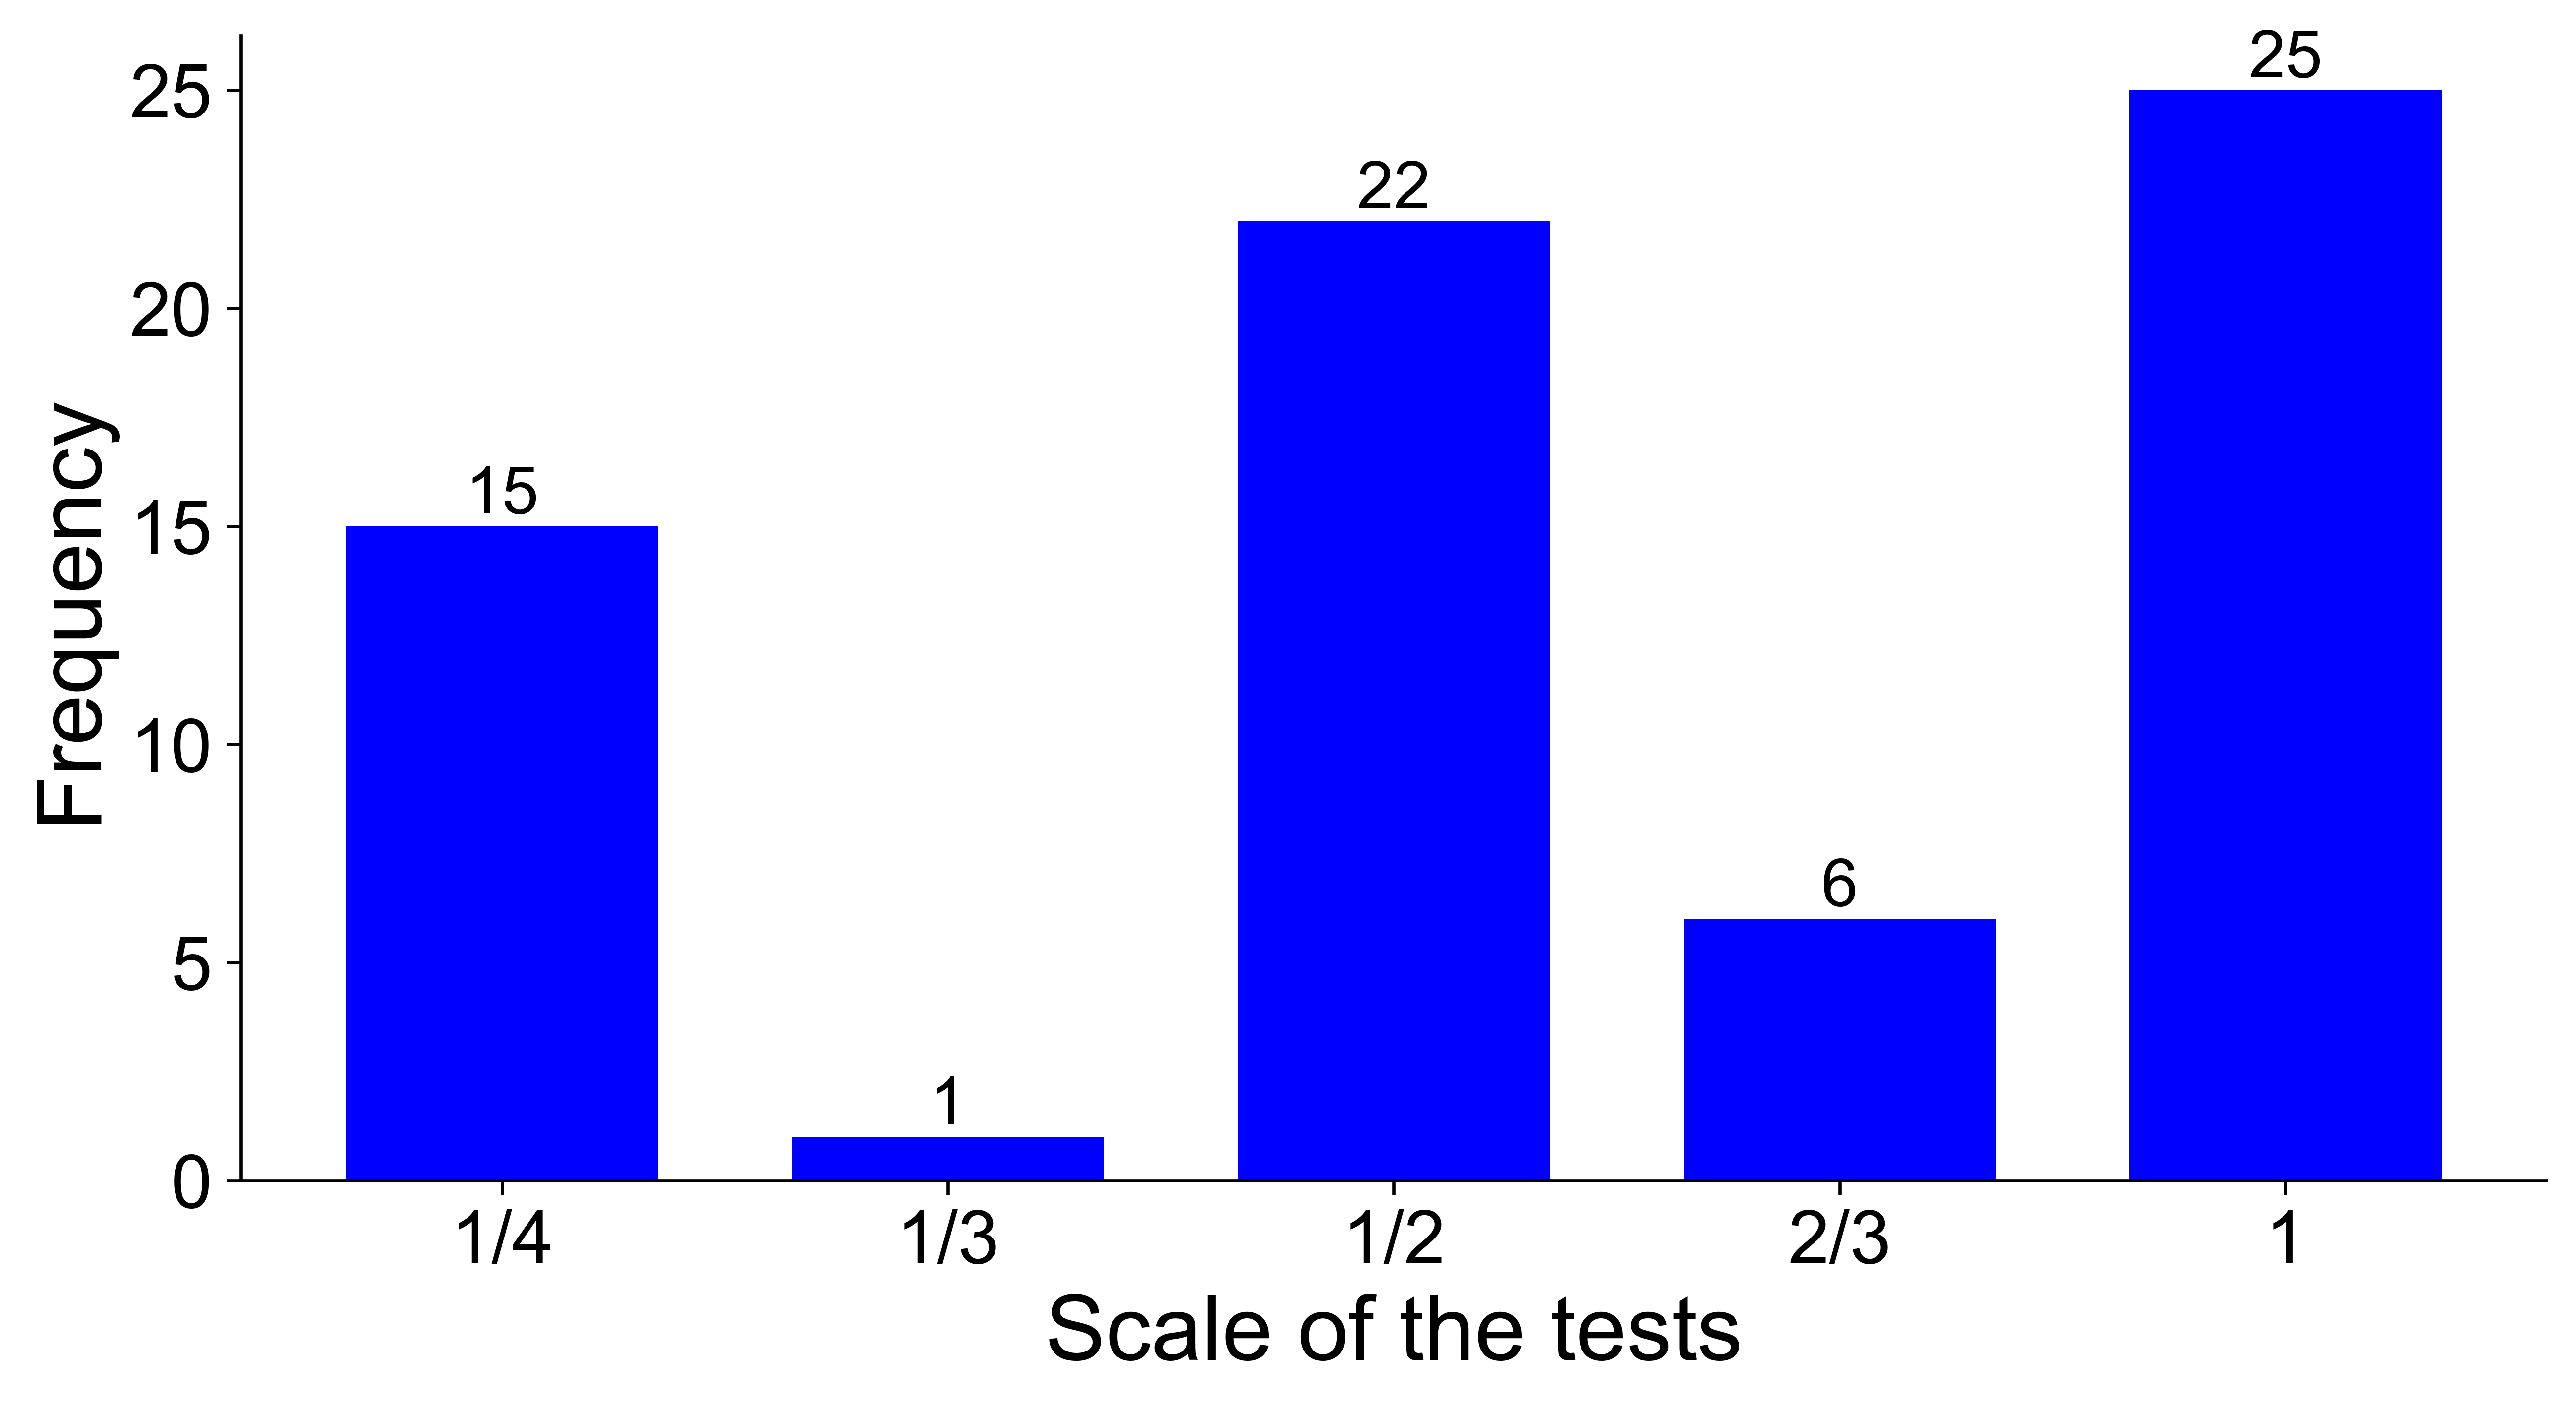

In [193]:
## Figure 1f: Bar plot for the scale of the tests

# Get variables for the scale of the test
scale = np.array(experiments["test_scale"])

scale_new = scale.copy()
for i in range(0, len(scale)):
    if scale[i] == 0.25:
        scale_new[i] = 1/4
    if scale[i] == 0.333:
        scale_new[i] = 1/3    
    if scale[i] == 0.5:
        scale_new[i] = 1/2
    if scale[i] == 0.667:
        scale_new[i] = 2/3
    if scale[i] == 1:
        scale_new[i] = 1

# Process data for the scale of the test  
_uF, varF = np.unique(scale_new, return_inverse=True)
rep_varF = np.bincount(varF)
XpF = np.array(varF)

# Plot figure
plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)
plt.bar(np.unique(XpF), rep_varF, color='b', width = w_val)

for i in range(len(rep_varF)):
    plt.text(np.unique(XpF)[i], rep_varF[i], f'{rep_varF[i]:.0f}',
             horizontalalignment='center',
             verticalalignment='bottom', fontsize=txt_font)

plt.xlabel('Scale of the tests', fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.xticks(np.unique(XpF),_uF)
ax = plt.gca()
tick_labels = ['1/4', '1/3', '1/2', '2/3', '1']
ax.set_xticklabels(tick_labels)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 1g - Statistics on the directionality of the applied excitations

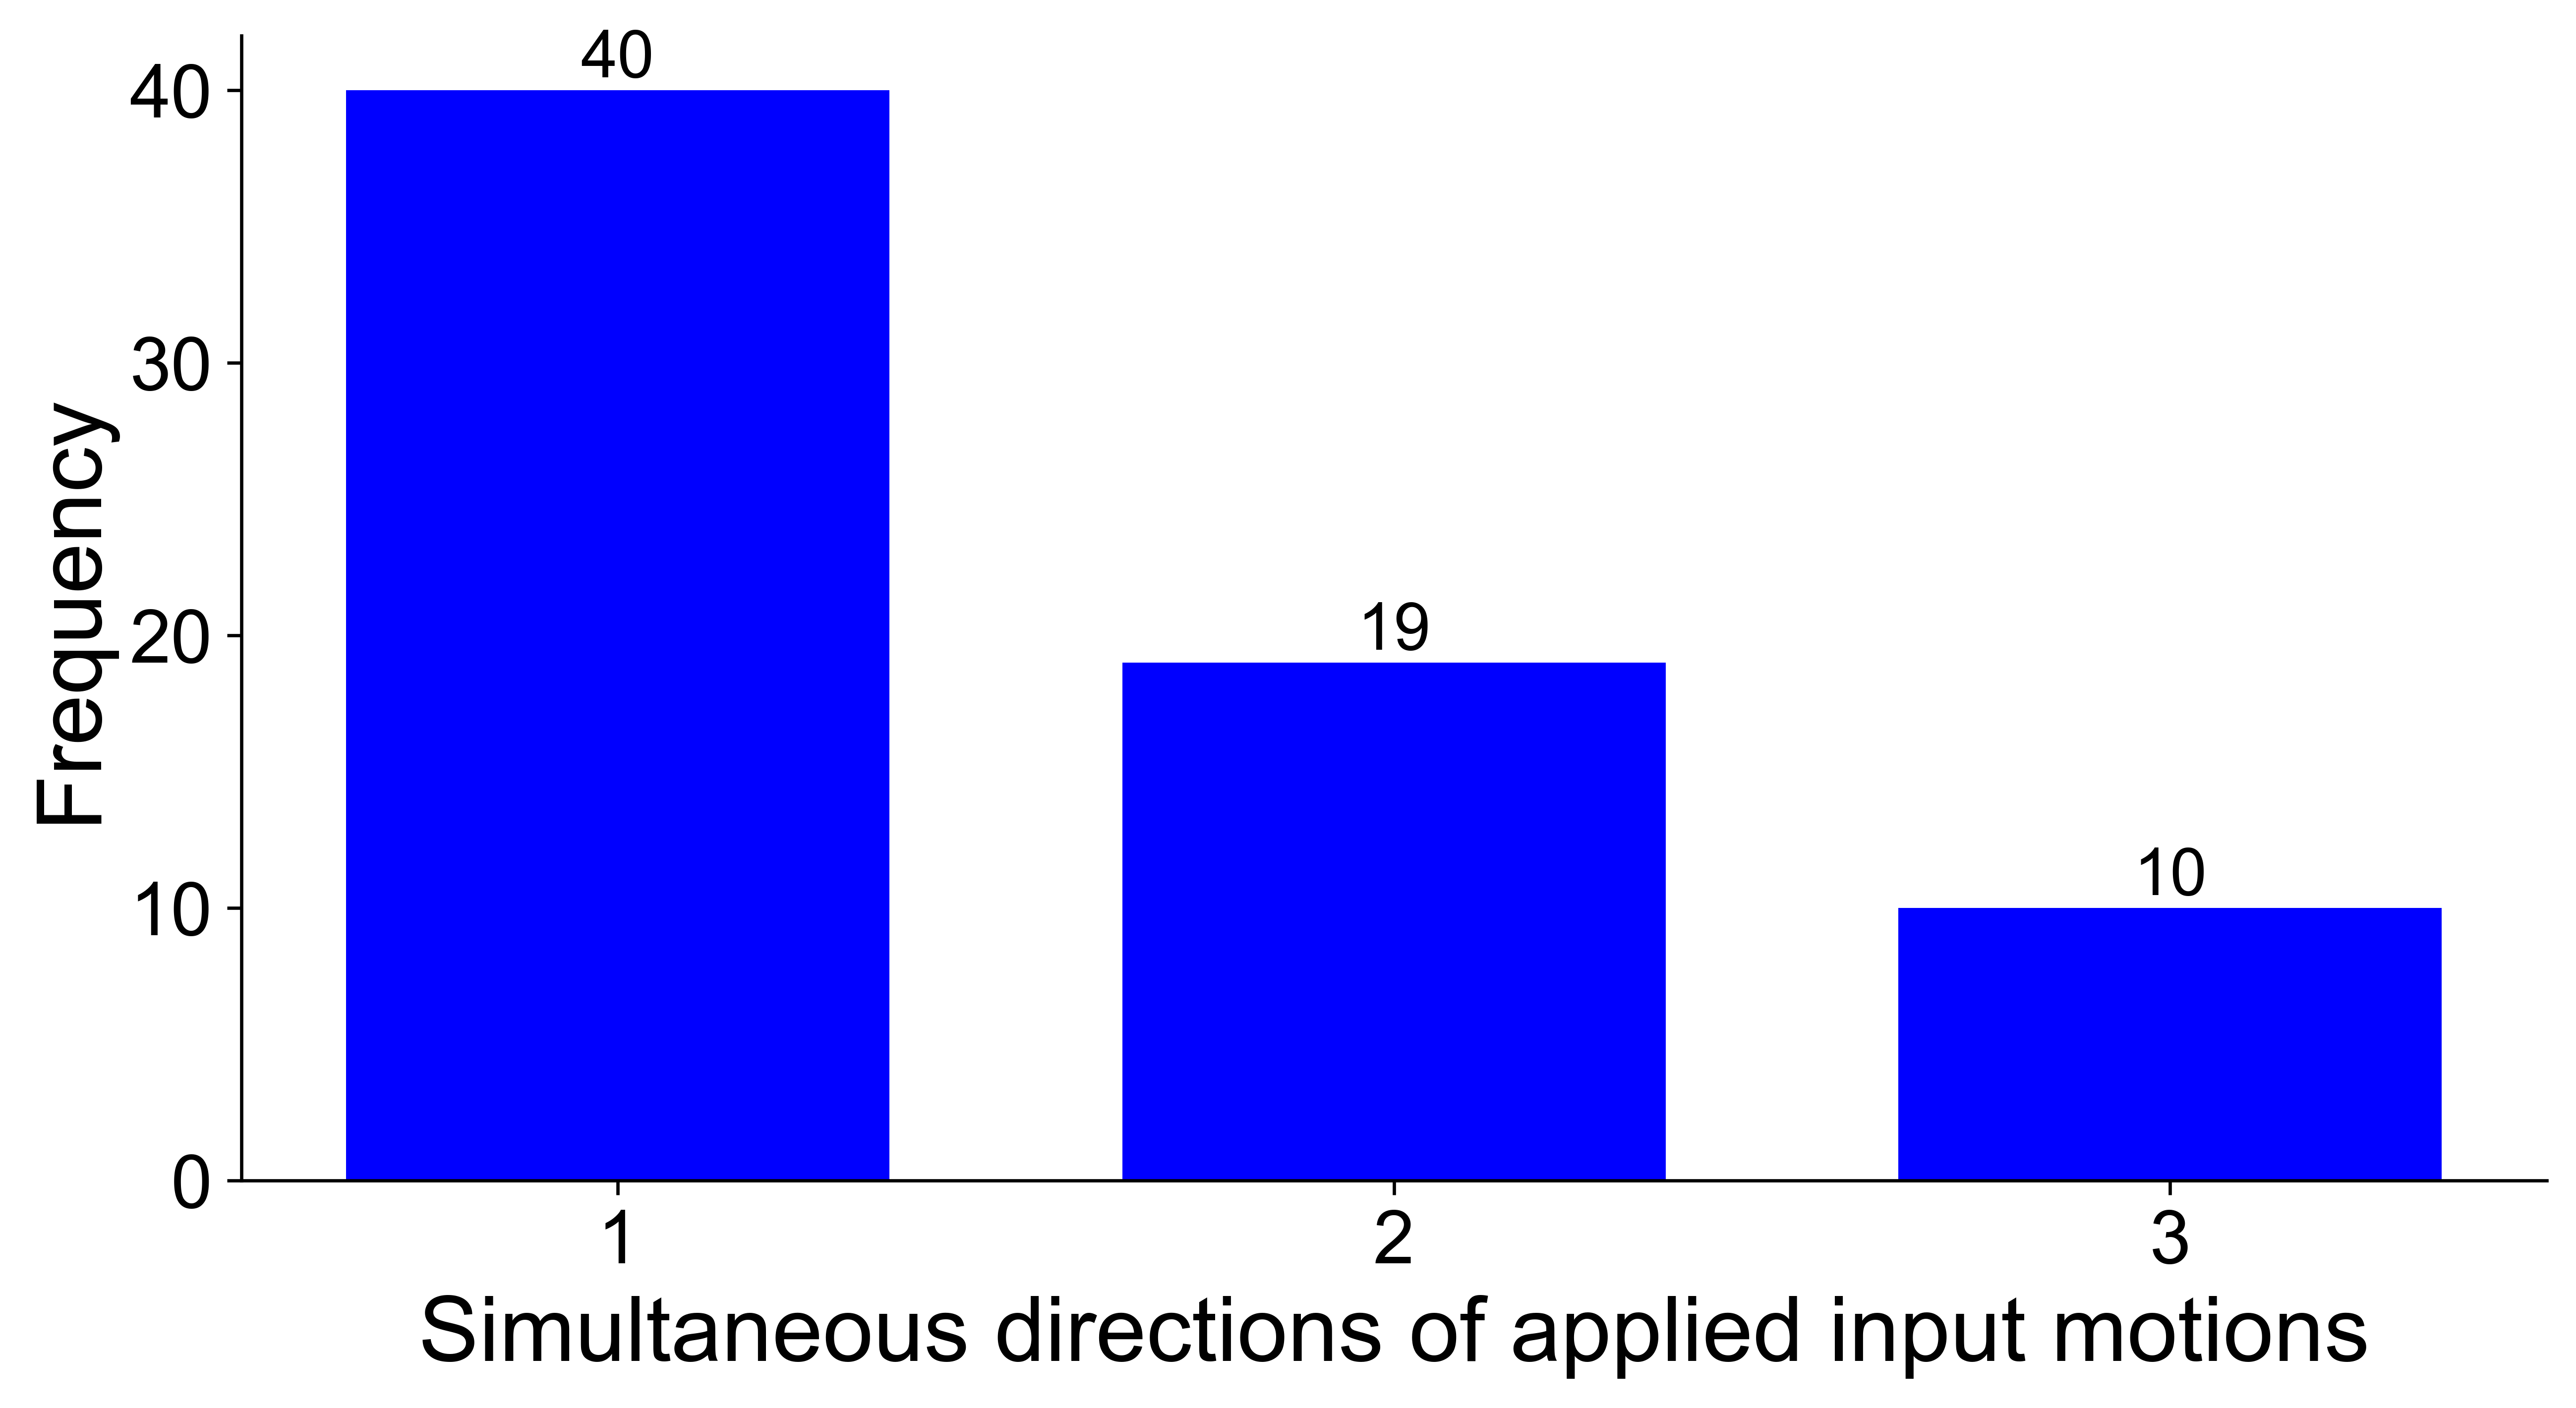

In [194]:
## Figure 1g: Bar plot for the direction of applied excitations

# Get variables for the direction of excitation
dir_input = np.array(experiments["simultaneous_excitations_nb"])

# Process data for the direction of excitation
_uG, varG = np.unique(dir_input, return_inverse=True)
rep_varG = np.bincount(varG)
XpG = np.array(varG)
tick_labels = _uG

# Plot figure
plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)
plt.bar(np.unique(XpG), rep_varG, color='b', width = w_val)

for i in range(len(rep_varG)):
    plt.text(np.unique(XpG)[i], rep_varG[i], f'{rep_varG[i]:.0f}',
             horizontalalignment='center',
             verticalalignment='bottom', fontsize=txt_font)

plt.xlabel('Simultaneous directions of applied input motions', fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.xticks(np.unique(XpG),_uG)
ax = plt.gca()
ax.set_xticklabels(tick_labels.astype(int))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 1h - Statistics on the retrofit condition

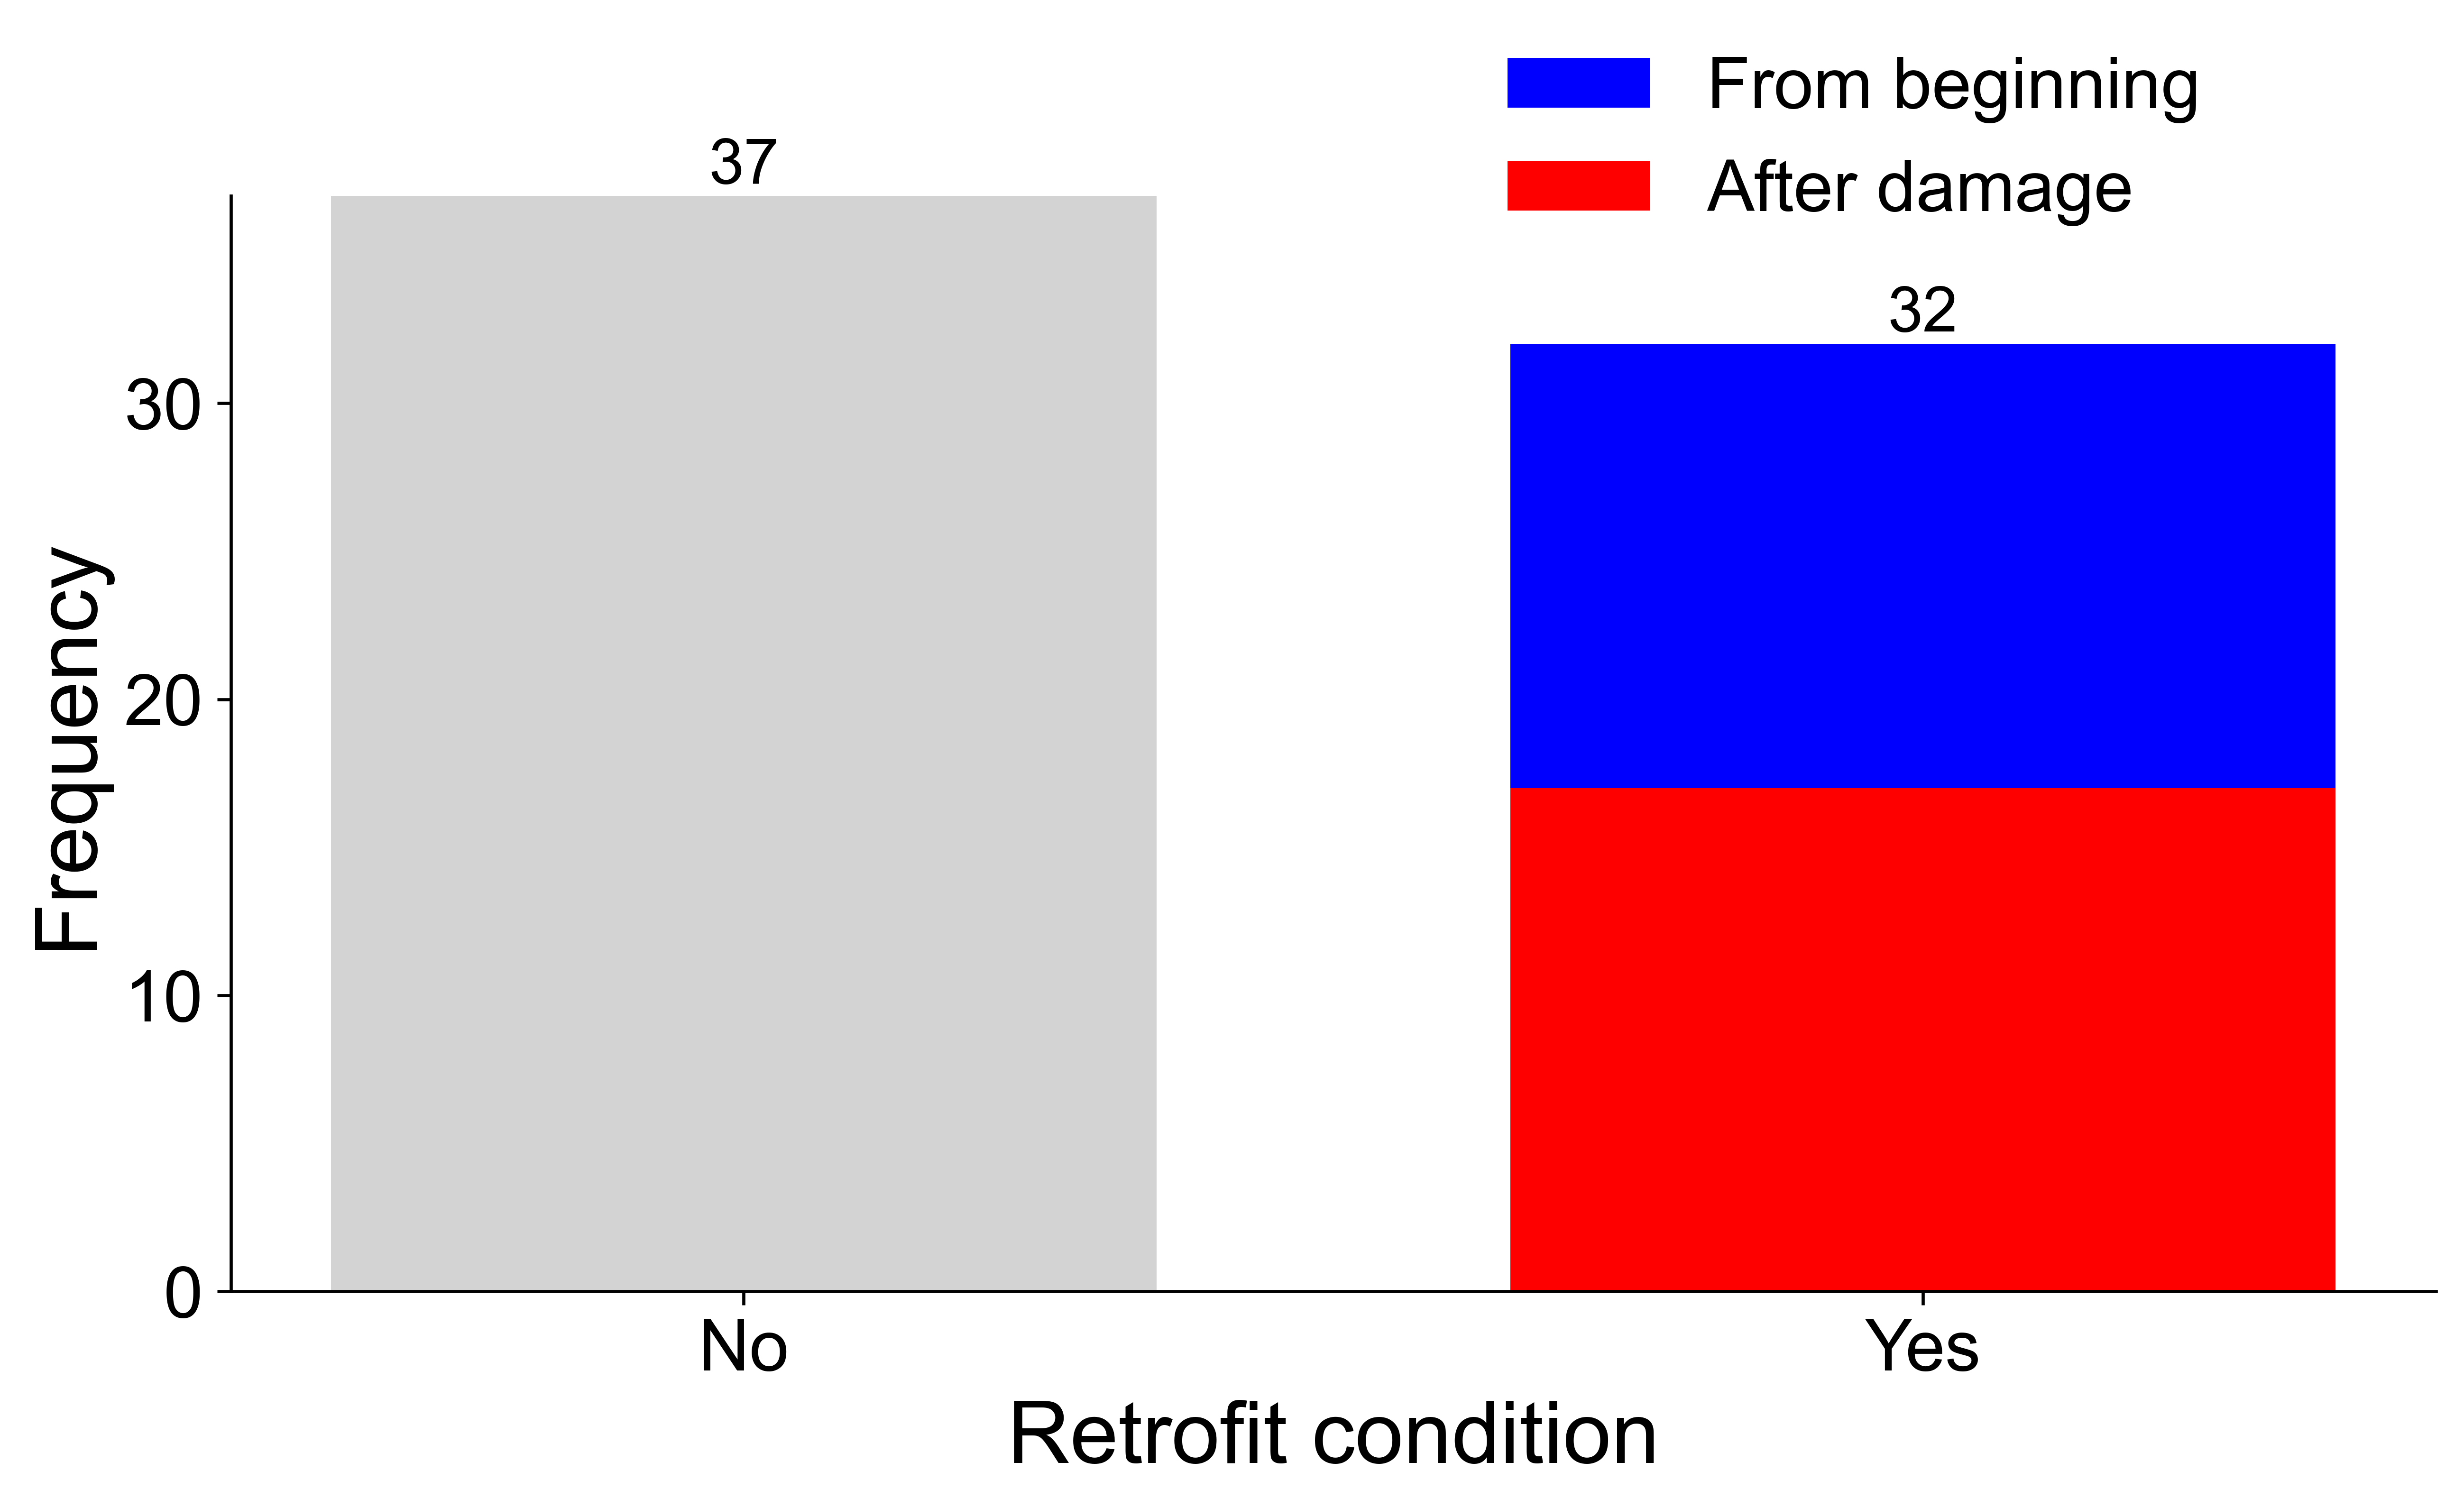

In [195]:
## Figure 1h: Bar plot for the retrofit condition

# Get variables for the condition of retrofit
retrof_cond = np.array(experiments["retrofitted"].map(lambda x: "Yes" if x else "No"))
retrof_applic = np.array(experiments["retrofitting_application"])

# Process data for the condition of retrofit
_uH1, varH1 = np.unique(retrof_cond, return_inverse=True)
_uH2, varH2 = np.unique(retrof_applic, return_inverse=True)
rep_varH1 = np.bincount(varH1)
rep_varH2 = np.bincount(varH2)
XpH1 = np.array(varH1)
XpH2 = np.array(varH2)
y1= np.zeros(2)
y2= np.zeros(2)

if 'no' in _uH1[0].casefold():
    y1[0] = rep_varH1[0]
    y1[1] = 0
else:
    y1[1] = rep_varH1[0]
    y1[0] = 0

if 'from beginning' in _uH2[0].casefold():
    y2[1] = rep_varH2[0]
if 'from beginning' in _uH2[1].casefold():
    y2[1] = rep_varH2[1]
if 'from beginning' in _uH2[2].casefold():
    y2[1] = rep_varH2[2]
if 'after damage' in _uH2[0].casefold():
    y2[1] = rep_varH2[0]
if 'after damage' in _uH2[1].casefold():
    y2[1] = rep_varH2[1]
if 'after damage' in _uH2[2].casefold():
    y2[1] = rep_varH2[2]

# Plot figure
plt.rcParams['font.size'] = plt_font
plt.figure(figsize=(10, 5), dpi=600)
plt.bar(np.unique(XpH1), rep_varH1, color='b', width = w_val)

plt.bar(np.unique(XpH1), y1, color='lightgray', label='_nolegend_', width = w_val)
plt.bar(np.unique(XpH1), y2, bottom=y1, color='r', width = w_val)

for i in range(len(rep_varH1)):
    plt.text(np.unique(XpH1)[i], rep_varH1[i], f'{rep_varH1[i]:.0f}',
             horizontalalignment='center',
             verticalalignment='bottom', fontsize=txt_font)

plt.xlabel('Retrofit condition', fontsize=axisLabel_font)
plt.ylabel('Frequency', fontsize=axisLabel_font)
plt.xticks(np.unique(XpH1),_uH1)
plt.legend(['From beginning','After damage'],ncol=1,bbox_to_anchor =(0.55, 1.05),loc='center left',frameon=False, fontsize=lgd_font+2)
ax = plt.gca()
tick_labels = _uH1
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.show()


### Figure 2 - Parallel plot of the key features of the database

In [196]:
# Create a copy of the database summary
df = experiments.copy()

#Set the names of the columns for which the information wants to be related in the parellel plot
subset_columns = ["masonry_unit_material","masonry_unit_type","diaphragm_material","wall_leaves_nb","storeys_nb","test_scale","simultaneous_excitations_nb","retrofitting_application"]

# Create a new DataFrame with only the desired columns
subset_df = df[subset_columns]

# Convert numpy arrays to lists
subset_df = subset_df.applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Replace strings to define new feature classes
subset_df["masonry_unit_material"] = subset_df["masonry_unit_material"].str.replace('.*stone.*', 'Stone', case=False, regex=True)
subset_df["masonry_unit_material"] = subset_df["masonry_unit_material"].str.replace('.*granite.*', 'Stone', case=False, regex=True)
subset_df["masonry_unit_material"] = subset_df["masonry_unit_material"].str.replace('.*calcium silicate.*', 'Calcium sil.', case=False, regex=True)
subset_df["masonry_unit_type"] = subset_df["masonry_unit_type"].str.replace('.*undressed.*', 'Undressed', case=False, regex=True)
subset_df["masonry_unit_type"] = subset_df["masonry_unit_type"].str.replace('.*Dressed.*', 'Dressed', case=True, regex=True)
subset_df["diaphragm_material"] = subset_df["diaphragm_material"].str.replace('.*&.*', 'Mixed', case=False, regex=True)
subset_df["diaphragm_material"] = subset_df["diaphragm_material"].str.replace('.*hollow.*', 'Mixed', case=False, regex=True)
subset_df["retrofitting_application"] = subset_df["retrofitting_application"].str.replace('.*not.*', 'Not applied', case=False, regex=True)

# Change the values of the "test_scale" to fraction numbers
numerator, denominator = Fraction(1/4).limit_denominator().as_integer_ratio()
fraction_to_replace = f"{numerator}/{denominator}"
subset_df["test_scale"] = subset_df["test_scale"].replace(1/4, fraction_to_replace)

numerator, denominator = Fraction(1/2).limit_denominator().as_integer_ratio()
fraction_to_replace = f"{numerator}/{denominator}"
subset_df["test_scale"] = subset_df["test_scale"].replace(1/2, fraction_to_replace)

numerator, denominator = Fraction(2/3).limit_denominator().as_integer_ratio()
fraction_to_replace = f"{numerator}/{denominator}"
subset_df["test_scale"] = subset_df["test_scale"].replace(0.667, fraction_to_replace)

numerator, denominator = Fraction(1/3).limit_denominator().as_integer_ratio()
fraction_to_replace = f"{numerator}/{denominator}"
subset_df["test_scale"] = subset_df["test_scale"].replace(0.333, fraction_to_replace)

# Define the categories to be considered in the parallel plot
categorical_dimensions = ["masonry_unit_material","masonry_unit_type","diaphragm_material","wall_leaves_nb","storeys_nb","test_scale","simultaneous_excitations_nb","retrofitting_application"]
dimensions = [dict(values=subset_df[label], label=label) for label in categorical_dimensions]

# Modify the 'dimensions' list to change the label
dimensions = [
    dict(values=subset_df[label], label='Masonry mat.' if label == "masonry_unit_material" else 'Unit type' if label == "masonry_unit_type" else 'Diaph. mat.' if label == "diaphragm_material" 
         else 'Retrofit' if label == "retrofitting_application" else 'Storeys' if label == "storeys_nb" else 'Wall-leaves' if label == "wall_leaves_nb"
         else 'Input dir.' if label == "simultaneous_excitations_nb" else 'Test scale' if label == "test_scale" else label) 
    for label in categorical_dimensions
]

# Build colorscale
direction_map = {'Clay': 0, 'Stone': 1, 'Calcium sil.': 2, 'Concrete': 3, 'Adobe': 4}
ec = subset_df
ec['mat_num'] = ec["masonry_unit_material"].map(direction_map)

color = ec.mat_num
colorscale = [[0, 'firebrick'], [0.20, 'firebrick'],
              [0.20, 'blue'], [0.40, 'blue'],
              [0.40, 'seagreen'], [0.60, 'seagreen'],
              [0.60, 'gray'], [0.80, 'gray'],
              [0.80, 'orange'], [1.0, 'orange']]

cmin = -0.5
cmax = 4.5

# Build figure
font_sz1 = 24
font_sz2 = 24
font_fam = 'Arial'

fig = go.Figure(
    
    data=[go.Parcats(domain={'y': [0.0, 0.0]}, dimensions=dimensions,
                 labelfont={'size': 38, 'family': font_fam},
                   line={'colorscale': colorscale, 'cmin': cmin,
                   'cmax': cmax, 'color': color, 'shape': 'hspline'})])

fig.update_layout(height=1000, width=2200, legend_tracegroupgap=100,
                  font={'size': font_sz1+18, 'family': font_fam, 'color': 'black'},
                  margin=dict(l=155, r=225, b=50, t=50))

fig.update_layout(
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.1
    ),
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)

fig.show()


### Figure 3 - Parallel plot of the observable failure mechanisms on masonry elements

In [197]:
# Parallel plot for type of cracks observed

# Convert numpy arrays to lists
subset_fail_mech = fail_mech.applymap(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

direction_map = {'Yes': 0, 'No': 1}
subset_fail_mech['shear_crack'] = subset_fail_mech["Shear at piers"].map(direction_map)

shear_cr_p = go.parcats.Dimension(values=subset_fail_mech["Shear at piers"], label='Shear cracks')
flex_cr_p = go.parcats.Dimension(values=subset_fail_mech["Flex. at piers"], label='Flexure cracks')
shear_cr_sp = go.parcats.Dimension(values=subset_fail_mech["Shear at spand."], label='Shear cracks')
flex_cr_sp = go.parcats.Dimension(values=subset_fail_mech["Flex. at spand."], label='Flexure cracks')
oop = go.parcats.Dimension(values=subset_fail_mech["Out-of-plane"], label='Out-of-plane')
crush = go.parcats.Dimension(values=subset_fail_mech["Brick crushing"], label='Unit crushing')

# Create parcats trace
color = subset_fail_mech.shear_crack
colorscale = [[0, 'red'], [0.50, 'red'],
              [0.50, 'gray'], [1.00, 'gray']]

fig = go.Figure(data=[go.Parcats(dimensions=[shear_cr_p, flex_cr_p, 
                                             shear_cr_sp, flex_cr_sp, oop, 
                                             crush], labelfont={'size': 32, 'family': font_fam},
                                 line={'color': color, 'shape': 'hspline', 'colorscale': colorscale},
                                 hoveron='dimension', hoverinfo='count', arrangement='freeform')])

fig.update_layout(height=500, width=1600,
                  font={'size': 32, 'family': font_fam, 'color': 'black'},
                  margin=dict(l=125, r=125, b=50, t=50, pad=30))

fig.show()


### Figure 4 - Box plots for the statistics on damage grade and intensity levels

In [198]:
# Read the data from database related to the PGA and attained DGs according to the clustering criterion selected

# Initialize variables to save attained PGAs
num_grades = 5 #number of damage grades considered (5 according to EMS-98 (Grünthal et al., 1998))
PGA_arrays = []

# Initialize variables to save damage grades
DG_arrays = []
DG_sort = [[] for _ in range(num_grades)]

# Initialize variables to save fundamental periods
T_ini_X = []
T_ini_Y = []
T_end_X = []
T_end_Y = []
T_X_arrays = []
T_Y_arrays = []

# Get desired information from the database
idxA1 = run_results["dg_derived"].values
idxA2 = run_results["dg_reported"].values
    
idxB1 = run_results["nominal_pga_x"].values
idxB2 = run_results["actual_pga_x"].values
    
idxC1 = run_results["nominal_pga_y"].values
idxC2 = run_results["actual_pga_y"].values

# Compare lists element-wise and get the maximum values, preserving non-NaN values
pgaX = [y if not np.isnan(y) else x for x, y in zip(idxB1, idxB2)]
pgaY = [y if not np.isnan(y) else x for x, y in zip(idxC1, idxC2)]
pga = np.nanmax([pgaX, pgaY], axis=0)

#Append PGAs
PGA_arrays.append(pga)

# Get information about damage grades
dg_rep = idxA1
dg_der = idxA2
dg = np.nanmax([dg_rep,dg_der], axis=0)

#Append DGs
DG_arrays.append(dg)
for j in range(0, num_grades):
    DG_sort[j].extend(pga[dg == j+1])
    
# Get information about the fundamental periods
T_X = run_t_results["reported_t1_x"].values
T_Y = run_t_results["reported_t1_y"].values

test_runs = np.array(run_results.groupby("experiment_id").size())
test_ini = 0
test_end = np.cumsum(test_runs)
for i in range(len(test_runs)):
    
    test_fin = test_end[i] + i + 1
    
    T_ini_X.append(T_X[test_ini])
    T_ini_Y.append(T_Y[test_ini])
  
    # Find the last numeric value (excluding NaN)
    last_numeric_value_X = next((x for x in reversed(T_X[test_ini:test_fin]) if not np.isnan(x)), np.nan)
    last_numeric_value_Y = next((x for x in reversed(T_Y[test_ini:test_fin]) if not np.isnan(x)), np.nan)
    
    T_X_arrays.append(T_X[test_ini+1:test_fin])
    T_Y_arrays.append(T_Y[test_ini+1:test_fin])
    
    # If the last numeric value is equal to the first value, assign np.nan
    if last_numeric_value_X is not None and last_numeric_value_X == T_ini_X[i]:
        last_numeric_value_X = np.nan
    if last_numeric_value_Y is not None and last_numeric_value_X == T_ini_Y[i]:
        last_numeric_value_Y = np.nan

    T_end_X.append(last_numeric_value_X)
    T_end_Y.append(last_numeric_value_Y)
    
    test_ini = test_ini + test_runs[i] + 1


In [199]:
# Frequency evolution  
f_fini_X = []
f_fini_Y = []

# Frequency evolution in the X-direction
for i in range(len(T_X_arrays)):
    
    s = pd.Series(T_X_arrays[i].flatten())
    
    if math.isnan(T_ini_X[i]):
        f_X_ratio = (1/T_X_arrays[i])/(1/T_X_arrays[i][s.first_valid_index()])
        f_fini_X.append(f_X_ratio)
    else:
        f_X_ratio = (1/T_X_arrays[i])/(1/T_ini_X[i])
        f_fini_X.append(f_X_ratio)

# Frequency evolution in the Y-direction        
for i in range(len(T_Y_arrays)):
    
    s = pd.Series(T_Y_arrays[i].flatten())
    
    if math.isnan(T_ini_Y[i]):
        f_Y_ratio = (1/T_Y_arrays[i])/(1/T_Y_arrays[i][s.first_valid_index()])
        f_fini_Y.append(f_Y_ratio)
    else:
        f_Y_ratio = (1/T_Y_arrays[i])/(1/T_ini_Y[i])
        f_fini_Y.append(f_Y_ratio)

flat_f_fini_X = np.concatenate([arr.flatten() for arr in f_fini_X], axis=0)
flat_f_fini_Y = np.concatenate([arr.flatten() for arr in f_fini_Y], axis=0)

In [200]:
# Include some experiments info with the run results
run_results2 = pd.merge(experiments[["id", "diaphragm_material", "masonry_unit_material_class", "retrofitting_application_new"]], run_results, left_on="id", right_on="experiment_id", suffixes=("_exp", ""))
run_results2.drop(columns=["id_exp"], inplace=True)

# Generate array with material of masonry for latter post-processing
diaph_series = np.array(run_results2["diaphragm_material"])

# Generate array with material of masonry for latter post-processing
mat_series = np.array(run_results2["masonry_unit_material_class"])

# Generate array with retrfit condition for latter post-processing
retrof_series = np.array(run_results2["retrofitting_application_new"])

#### Figure 4a - Box plots for PGA vs. DG (for all type of masonry)

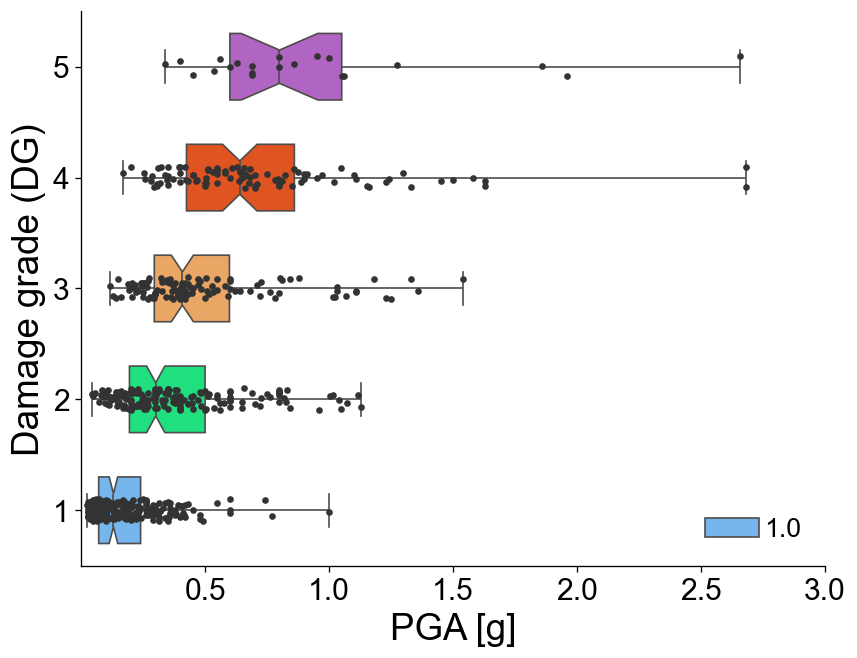

In [201]:
# Figure 4a - Box plots for PGA vs. DG

# Flatten arrays to facilitate their manipulation
flat_PGA_arrays = np.concatenate(PGA_arrays)
flat_DG_arrays = np.concatenate(DG_arrays)
data_box = {'PGAs': flat_PGA_arrays, 'DGs': flat_DG_arrays}

data_format = pd.DataFrame(data_box)
data_cleaned = data_format.dropna().copy()

# Convert 'DGs' column to categorical type
data_cleaned['DGs'] = data_cleaned['DGs'].astype('category')

# Initialize the figure with a logarithmic x axis
plt.rcParams['font.size'] = plt_font
f, ax = plt.subplots(figsize=(8, 6), dpi=120)

# Plot horizontal boxes
my_palette = ["#63B8FF", "#00FF7F", "#FFA54F", "#FF4500", "#BA55D3"]
sns.boxplot(x="PGAs", y="DGs", data=data_cleaned,
            whis=[0, 100], width=.6, palette=my_palette, hue="DGs", notch=True) #whis=[0, 100]

# Add in points to show each observation
g = sns.stripplot(x="PGAs", y="DGs", data=data_cleaned,
              size=4, color=".2", linewidth=0, label='Single test')

# Tweak the visual presentation
ax.invert_yaxis()
ax.set_xticks([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_xlim([0, 3.0])
ax.set_xlabel("PGA [g]", fontsize=axisLabel_font)
ax.set_ylabel("Damage grade (DG)", fontsize=axisLabel_font)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
handles,labels = g.get_legend_handles_labels()
handles = [handles[0]]
g.legend(handles,labels,frameon=False, fontsize=lgd_font, handletextpad=0.2, loc='lower right')

plt.show()


#### Figure 4b - Box plots for DI vs. DG (DI = Damage indicator) for clay masonry

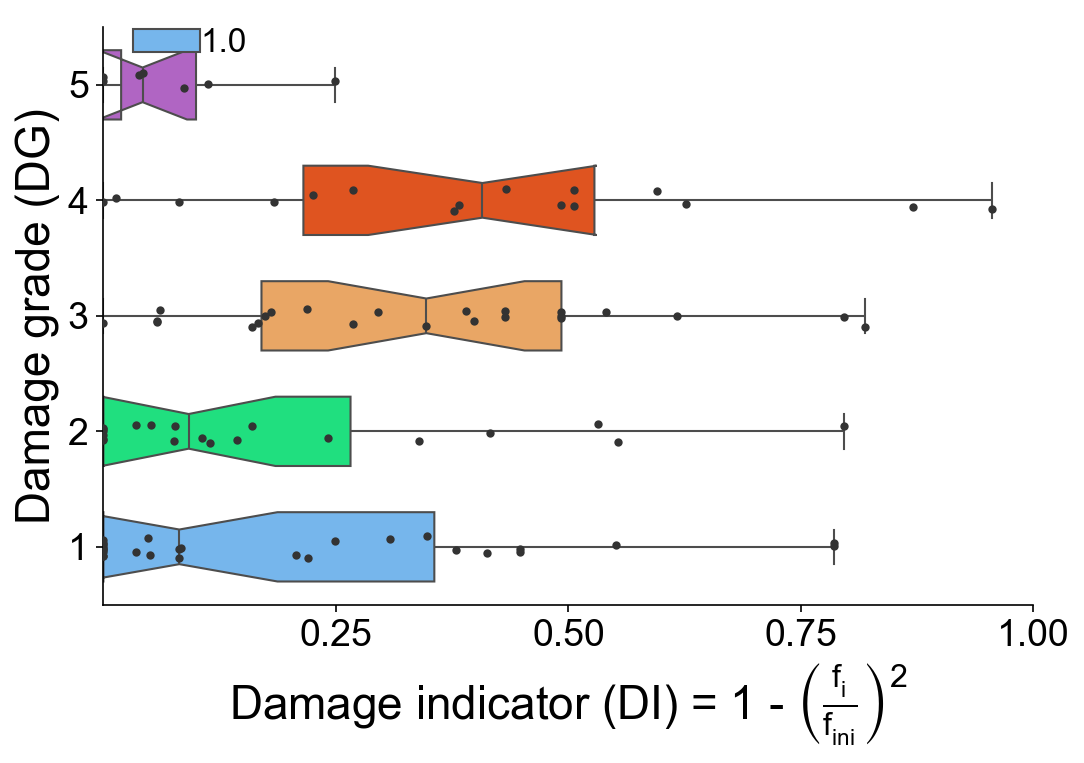

In [202]:
# Figure 4b - Box plots for DI vs. DG (DI = Damage indicator) for clay masonry

# Initialize variables
freq_mat_clay = []
freq_mat_clay_no_retrof = []
DG_mat_clay = []
DG_mat_clay_no_retrof = []
ref_mat_clay_no_retrof = []
val_diff = 0.0

# Reshape data of change in fundamental frequencies
for i in range(0, len(flat_DG_arrays)):
    if mat_series[i] == 'Clay':
        
        # for frequencies in the X-direction
        aux = 1-flat_f_fini_X[i]*flat_f_fini_X[i]
        aux = np.where(aux<0, np.nan, aux)

        freq_mat_clay.append(aux)
        DG_mat_clay.append(flat_DG_arrays[i])
        
        if retrof_series[i] == 'Not retrofitted' or retrof_series[i] == 'From beginning':
            freq_mat_clay_no_retrof.append(aux)
            DG_mat_clay_no_retrof.append(flat_DG_arrays[i])
        
        # for frequencies in the Y-direction
        aux = 1-flat_f_fini_Y[i]*flat_f_fini_Y[i]
        aux = np.where(aux<0, np.nan, aux)
        
        freq_mat_clay.append(aux)
        DG_mat_clay.append(flat_DG_arrays[i])
        
        if retrof_series[i] == 'Not retrofitted' or retrof_series[i] == 'From beginning':
            freq_mat_clay_no_retrof.append(aux)
            DG_mat_clay_no_retrof.append(flat_DG_arrays[i])

DG_clay = [[] for _ in range(num_grades)]
for i in range(0, num_grades):
    ind_clay = [index for index, subarray in enumerate(DG_mat_clay) if np.all(subarray == i+1)]
    extracted_values = [freq_mat_clay[index] for index in ind_clay]
    DG_clay[i].extend(np.array(extracted_values))

# Flaten variables to facilitate their manipulation
flat_freqs_clay_arrays = np.concatenate([arr.flatten() for arr in freq_mat_clay_no_retrof], axis=0)

data_box = {'freqs': flat_freqs_clay_arrays, 'DGs': DG_mat_clay_no_retrof}

# Format data
data_format = pd.DataFrame(data_box)
data_cleaned = data_format.dropna().copy()

# Convert 'DGs' column to categorical type
data_cleaned['DGs'] = data_cleaned['DGs'].astype('category')

# Initialize the figure with a logarithmic x axis
plt.rcParams['font.size'] = plt_font
f, ax = plt.subplots(figsize=(8, 5), dpi=150)

# Plot horizontal boxes
my_palette = ["#63B8FF", "#00FF7F", "#FFA54F", "#FF4500", "#BA55D3"]
sns.boxplot(x="freqs", y="DGs", data=data_cleaned,
            whis=[0, 100], width=.6, palette=my_palette, hue="DGs", notch=True) #whis=[0, 100]

# Add in points to show each observation
g = sns.stripplot(x="freqs", y="DGs", data=data_cleaned,
              size=4, color=".2", linewidth=0, label='Clay masonry tests')

# Tweak the visual presentation
ax.invert_yaxis()
ax.set_xticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_xlim([0, 1.0])
ax.set_xlabel(r"Damage indicator (DI) = 1 - $\mathregular{\left(\frac{f_{i}}{f_{ini}}\right)^{2}}$", fontsize=axisLabel_font)
ax.set_ylabel("Damage grade (DG)", fontsize=axisLabel_font)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
handles,labels = g.get_legend_handles_labels()
handles = [handles[0]]
g.legend(handles,labels,frameon=False, fontsize=lgd_font, handletextpad=0.01, loc='upper left', bbox_to_anchor=(0, 1.05))

plt.show()


#### Figure 4c - Box plots for DI vs. DG (DI = Damage indicator) for stone masonry

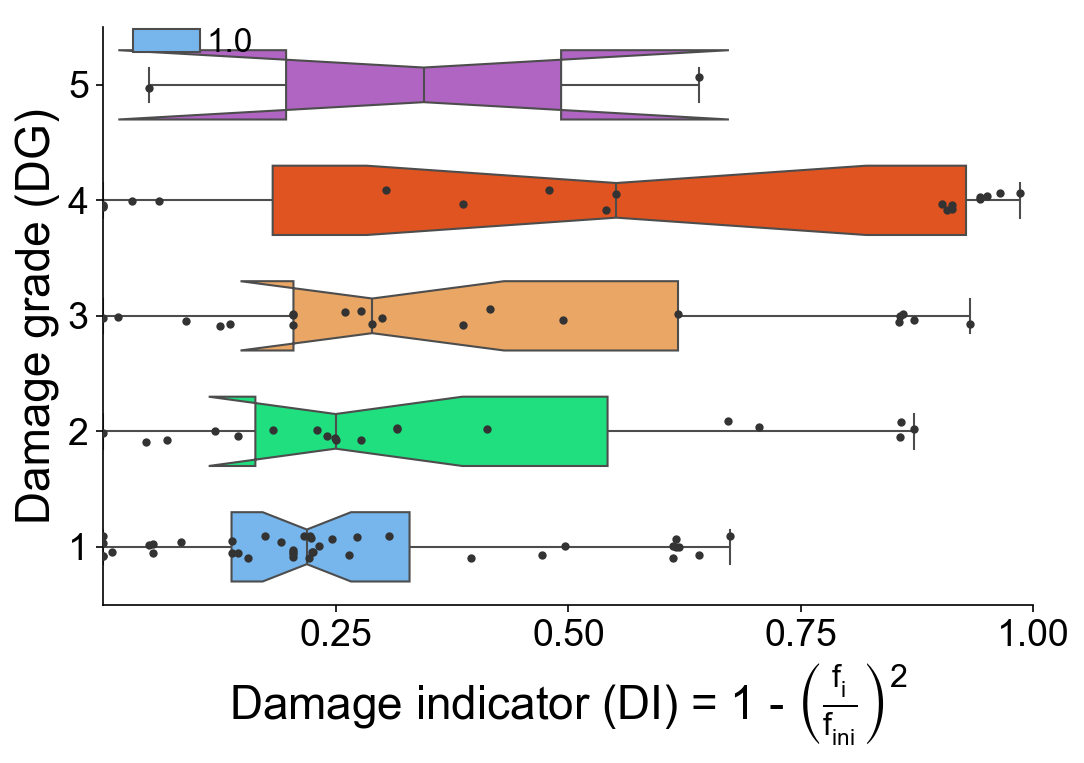

In [203]:
# Figure 4c - Box plots for DI vs. DG (DI = Damage indicator) for stone masonry

# Initialize variables
freq_mat_stone = []
freq_mat_stone_no_retrof = []
DG_mat_stone = []
DG_mat_stone_no_retrof = []
ref_mat_stone_no_retrof = []
val_diff = 0.0

for i in range(0, len(flat_DG_arrays)):

    if mat_series[i] == 'Stone':
        
        # for frequencies in the X-direction
        aux = 1-flat_f_fini_X[i]*flat_f_fini_X[i]
        aux = np.where(aux<0, np.nan, aux)
        
        freq_mat_stone.append(aux)
        DG_mat_stone.append(flat_DG_arrays[i])
        
        if retrof_series[i] == 'Not retrofitted' or retrof_series[i] == 'From beginning':
            freq_mat_stone_no_retrof.append(aux)
            DG_mat_stone_no_retrof.append(flat_DG_arrays[i])
            
        # for frequencies in the Y-direction
        aux = 1-flat_f_fini_Y[i]*flat_f_fini_Y[i]
        aux = np.where(aux<0, np.nan, aux)
        
        freq_mat_stone.append(aux)
        DG_mat_stone.append(flat_DG_arrays[i])
        
        if retrof_series[i] == 'Not retrofitted' or retrof_series[i] == 'From beginning':
            freq_mat_stone_no_retrof.append(aux)
            DG_mat_stone_no_retrof.append(flat_DG_arrays[i])

DG_stone = [[] for _ in range(num_grades)]
for i in range(0,num_grades):
    ind_stone = [index for index, subarray in enumerate(DG_mat_stone) if np.all(subarray == i+1)]
    extracted_values = [freq_mat_stone[index] for index in ind_stone]
    DG_stone[i].extend(np.array(extracted_values))
                  
# Flaten variables to facilitate their manipulation
flat_freqs_stone_arrays = np.concatenate([arr.flatten() for arr in freq_mat_stone_no_retrof], axis=0)

data_box = {'freqs': flat_freqs_stone_arrays, 'DGs': DG_mat_stone_no_retrof}
data_format = pd.DataFrame(data_box)
data_cleaned = data_format.dropna().copy()

# Convert 'DGs' column to categorical type
data_cleaned['DGs'] = data_cleaned['DGs'].astype('category')

# Initialize the figure with a logarithmic x axis
plt.rcParams['font.size'] = plt_font
f, ax = plt.subplots(figsize=(8, 5), dpi=150)

# Plot horizontal boxes
my_palette = ["#63B8FF", "#00FF7F", "#FFA54F", "#FF4500", "#BA55D3"]
sns.boxplot(x="freqs", y="DGs", data=data_cleaned,
            whis=[0, 100], width=.6, palette=my_palette, hue="DGs", notch=True) #whis=[0, 100]

# Add in points to show each observation
g = sns.stripplot(x="freqs", y="DGs", data=data_cleaned,
              size=4, color=".2", linewidth=0, label='Stone masonry tests')

# Tweak the visual presentation
ax.invert_yaxis()
ax.set_xticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['1', '2', '3', '4', '5'])
ax.set_xlim([0, 1.0])
ax.set_xlabel(r"Damage indicator (DI) = 1 - $\mathregular{\left(\frac{f_{i}}{f_{ini}}\right)^{2}}$", fontsize=axisLabel_font)
ax.set_ylabel("Damage grade (DG)", fontsize=axisLabel_font)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
handles,labels = g.get_legend_handles_labels()
handles = [handles[0]]
g.legend(handles,labels,frameon=False, fontsize=lgd_font, handletextpad=0.2, loc='upper left', bbox_to_anchor=(0, 1.05))

plt.show()


### Figure 6 - Fragility curves

In [204]:
# Plotting features
markers = ['o','x','s','h','d','*','^']
grayColor = [.7, .7, .7]
mk_size = 4
ln_width = 1.2
font_size = 18
font_name = 'times'

# PGA intervals and thresholds
dPGA = 0.1
maxPGA = 2.0
PGA_int = np.arange(0, maxPGA + dPGA, dPGA)
PGA_thresh = np.arange(0.025, 1.275, 0.025)
num_PGA_thresh = len(PGA_thresh)

# Plotting variables
x = np.linspace(0.0001, 1.25, 1000)  # Range of x-values for CDF
colors = [(0.0, 0.0, 1.0), (1.0, 0.0, 0.0), (0.0027178966103330593, 0.9927448218736624, 0.2096938325146771), (1.0, 0.0, 1.0), (1.0, 0.5, 0.0), 
          (0.0, 0.5, 1.0), (0.5, 0.25, 0.5), (0.3958559221905318, 0.15022928632167176, 0.5712033086861699), 
          (0.0027178966103330593, 0.9927448218736624, 0.2096938325146771), (0.0, 0.788, 0.34), (1.0, 0.0, 0.0), (0.9445261346160424, 0.5010625827104216, 0.9553157613565093), 
          (0.5, 0.25, 0.5), (0.006484811262111756, 0.49608846039512966, 0.20485522862687366), (0.2586757463067827, 0.9814101127065736, 0.9564370251024708)]
plt_font = 22 #fontsize for ticks in the plots
lgd_font = 20 #fontsize for legend in the plots
txt_font = 20 #fontsize for text embedded in the plots



#### Figure 6a - Fragility curves for classification based on type of masonry (brick or stone)

DG1 - theta_Stone:  0.15
DG1 - beta_Stone:  0.75
 
DG1 - theta_Brick:  0.12
DG1 - beta_Brick:  0.75
 


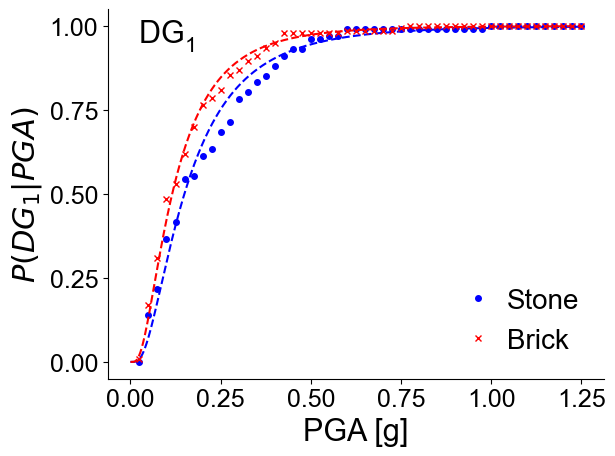

DG2 - theta_Stone:  0.31
DG2 - beta_Stone:  0.72
 
DG2 - theta_Brick:  0.3
DG2 - beta_Brick:  0.65
 


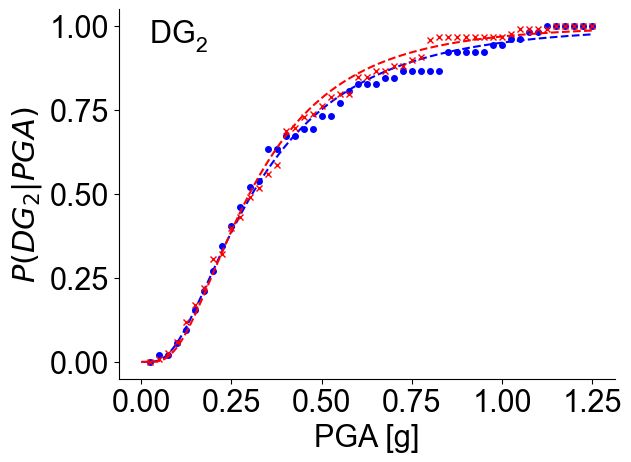

DG3 - theta_Stone:  0.41
DG3 - beta_Stone:  0.59
 
DG3 - theta_Brick:  0.43
DG3 - beta_Brick:  0.6
 


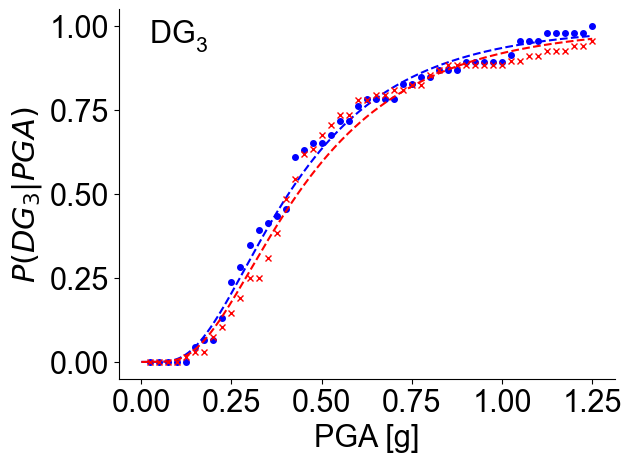

DG4 - theta_Stone:  0.54
DG4 - beta_Stone:  0.49
 
DG4 - theta_Brick:  0.66
DG4 - beta_Brick:  0.54
 


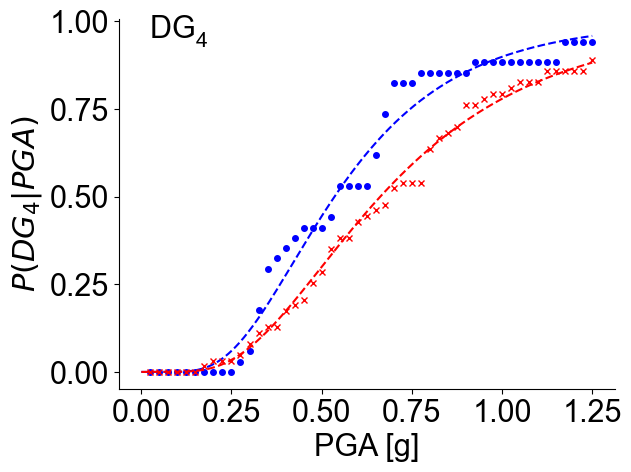

DG5 - theta_Stone:  0.63
DG5 - beta_Stone:  0.47
 
DG5 - theta_Brick:  0.84
DG5 - beta_Brick:  0.4
 


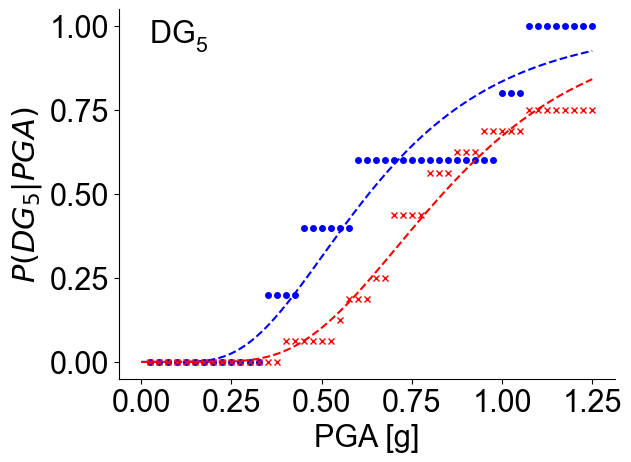

In [205]:
#Building clustering criteria
xp = mat_series.copy()
clust_1 = 'Mat' #clustering based on the material of the masonry
clust_select = clust_1

# Clustering 1: For masonry unit material
if clust_select == clust_1:
    
    # Get info about masonry material
    stone_types = ['calcareous', 'sandstone', 'limestone', 'granite', 'tuff']

    feature = ['Stone', 'Brick'] # features for the selection
    for i, value in enumerate(mat_series):
        if any(stone_type in value.lower() for stone_type in stone_types[:3]):
            xp[i] = feature[0]
        elif any(stone_type in value.lower() for stone_type in stone_types[3:]):
            xp[i] = feature[0]
        elif 'clay' in value.lower():
            xp[i] = feature[1]
        elif 'calcium' in value.lower():
            xp[i] = feature[1]    
        elif 'concrete' in value.lower():
            xp[i] = feature[1]
        elif 'mortar' in value.lower():
            xp[i] = feature[1]    
        elif 'adobe' in value.lower():
            xp[i] = feature[1]
        else:
            xp[i] = feature[0]
    
    class_ = xp

# Initialize arrays of variables to be saved  
num_features = len(feature)
p_exceed_DG = [[[] for _ in range(num_features)] for _ in range(num_grades)]
count = [[[0 for _ in range(num_PGA_thresh)] for _ in range(num_features)] for _ in range(num_grades)]

# Create a dictionary to store separated arrays
separated_arrays = {}

# Iterate through the data and populate the dictionary
for pgas, dgs, m in zip(pga, dg, xp):
    key = (dgs, m)
    if key not in separated_arrays:
        separated_arrays[key] = []
    separated_arrays[key].append(pgas)
    
# Convert the lists in the dictionary to NumPy arrays
for key in separated_arrays:
    separated_arrays[key] = np.array(separated_arrays[key])

# Create a copy of the array for post-processing DG values
DG = separated_arrays.copy()

#Count values that are below a certain pga value
for i in range(0, num_features):
    for j in range(0, num_PGA_thresh):
        count[0][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(1,feature[i])])
        count[1][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(2,feature[i])])
        count[2][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(3,feature[i])])
        count[3][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(4,feature[i])])
        count[4][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(5,feature[i])])
        
        p_exceed_DG[0][i].append(count[0][i][j] / np.sum(~np.isnan(DG[(1,feature[i])])))
        p_exceed_DG[1][i].append(count[1][i][j] / np.sum(~np.isnan(DG[(2,feature[i])])))
        p_exceed_DG[2][i].append(count[2][i][j] / np.sum(~np.isnan(DG[(3,feature[i])])))
        p_exceed_DG[3][i].append(count[3][i][j] / np.sum(~np.isnan(DG[(4,feature[i])])))
        p_exceed_DG[4][i].append(count[4][i][j] / np.sum(~np.isnan(DG[(5,feature[i])])))

# Maximum log-likelihood estimator to fit lognormal distribution to empirical data
IM = PGA_thresh
theta = np.zeros((num_grades, num_features))
beta = np.zeros((num_grades, num_features))

for i in range(0, num_grades):
    for j in range(0, num_features):
        if ~np.isnan(p_exceed_DG[i][j]).any() and np.count_nonzero(p_exceed_DG[i][j]) != 0 and ~np.isin(p_exceed_DG[i][j], [0, 1]).all():
            _, theta[i][j], beta[i][j] = probit_function(IM, p_exceed_DG[i][j])

# Plot the fragilities
for i in range(0, num_grades):
    for j in range(0, num_features):
        if theta[i][j] != 0:
            print('DG' + str(i+1) + ' - theta_' + str(feature[j]) +  ': ', round(theta[i][j],2))
            print('DG' + str(i+1) + ' - beta_' + str(feature[j]) +  ': ', round(beta[i][j],2))
            print(' ')
            y = lognorm.cdf(x, beta[i][j], scale=theta[i][j])  # Calculate the CDF for each x-value
            
            plt.plot(x, y, '--', color=colors[j])
            plt.plot(PGA_thresh, p_exceed_DG[i][j], markers[j], color=colors[j], markersize=mk_size, label=feature[j])
    
    plt.text(0.02, 0.95, "$\mathregular{DG_"+ str(i+1)+"}$", fontsize = 22)
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
    plt.xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25])
    if i == 0:
        plt.legend(frameon=False, fontsize=lgd_font, handletextpad=0.01)
    
    plt.rcParams['font.size'] = plt_font
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    plt.xlabel('PGA [g]', fontsize=axisLabel_font)
    plt.ylabel(r"$P(DG_{"+ str(i+1)+"} | PGA)$", fontsize=axisLabel_font)   

    plt.show()


#### Figure 6b - Fragility curves for classification based on type of diaphragm (flexible or rigid)

DG1 - theta_Flexible:  0.13
DG1 - beta_Flexible:  0.79
 
DG1 - theta_Rigid:  0.1
DG1 - beta_Rigid:  0.8
 


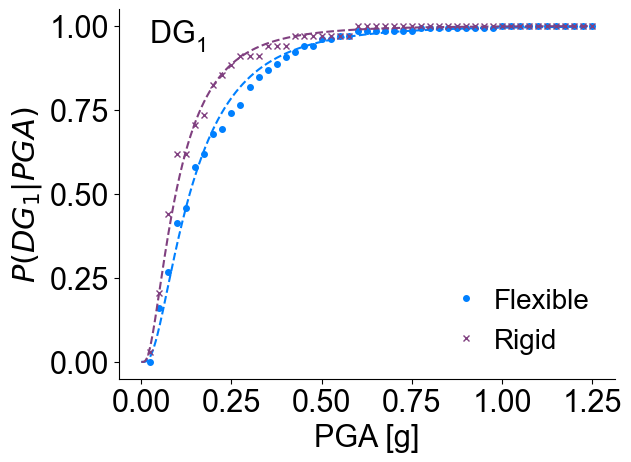

DG2 - theta_Flexible:  0.29
DG2 - beta_Flexible:  0.68
 
DG2 - theta_Rigid:  0.25
DG2 - beta_Rigid:  0.7
 


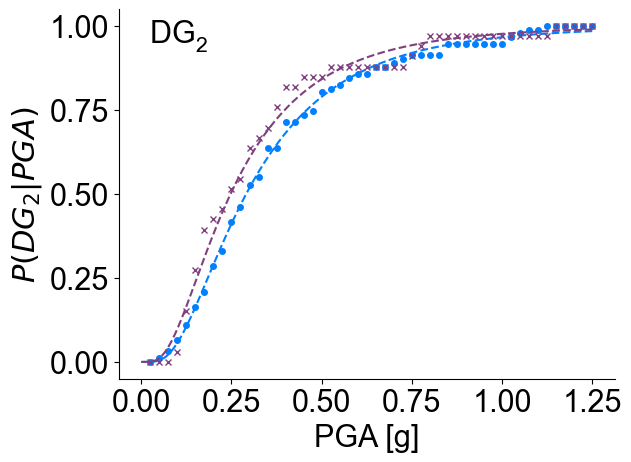

DG3 - theta_Flexible:  0.39
DG3 - beta_Flexible:  0.52
 
DG3 - theta_Rigid:  0.42
DG3 - beta_Rigid:  0.66
 


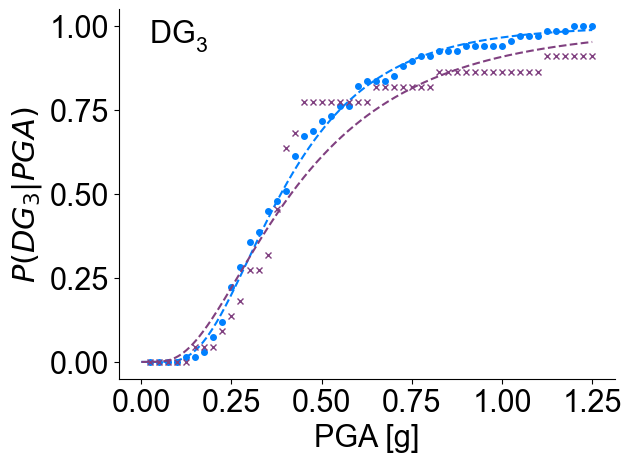

DG4 - theta_Flexible:  0.56
DG4 - beta_Flexible:  0.46
 
DG4 - theta_Rigid:  0.75
DG4 - beta_Rigid:  0.46
 


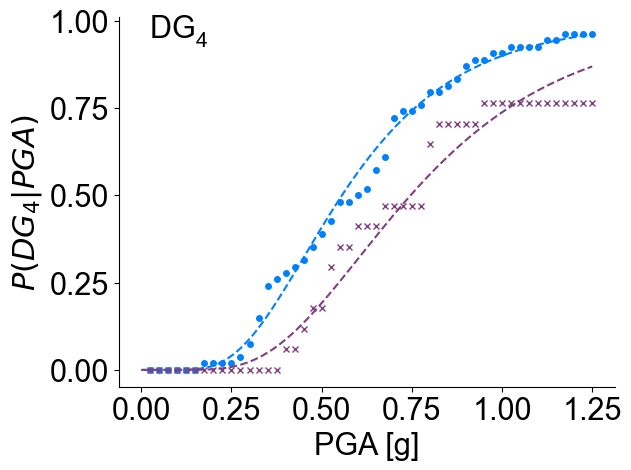

DG5 - theta_Flexible:  0.72
DG5 - beta_Flexible:  0.29
 
DG5 - theta_Rigid:  0.83
DG5 - beta_Rigid:  0.27
 


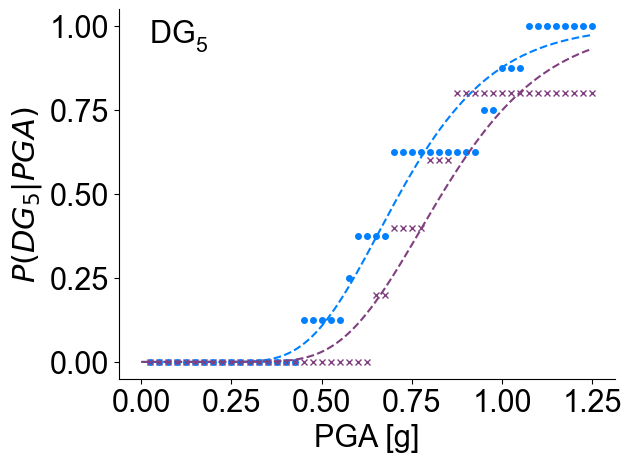

In [206]:
#Building clustering criteria
xp = []
clust_2 = 'Diaph'         #clustering based on the type of diaphragm
clust_select = clust_2

# Clustering 2: For diaphragm material
if clust_select == clust_2:

    xp_aux = [] # auxiliary variable
    
    # Features for the selection
    stone_types = ['calcareous', 'sandstone', 'limestone', 'granite', 'tuff']
    feature = ['Flexible', 'Rigid', 'No diaph.']
    
    for i in range(len(mat_series)):
        xp.append([mat_series[i], diaph_series[i]])

    for i, value in enumerate(xp):
        if value[0] == 'Clay' and value[1] == 'Timber':
            xp_aux.append(feature[0])
        elif value[0] == 'Clay' and value[1] == 'RC':
            xp_aux.append(feature[1])
        elif value[0] == 'Clay' and value[1] == 'Mixed': #this is treated as RC (rigid diaphragm)
            xp_aux.append(feature[1])
        elif value[0] == 'Clay' and value[1] != 'N/A':
            xp_aux.append(feature[2])
            
        elif value[0] == 'Stone' and value[1] == 'Timber':
            xp_aux.append(feature[0])
        elif value[0] == 'Stone' and value[1] == 'RC':
            xp_aux.append(feature[1])
        elif value[0] == 'Stone' and value[1] == 'Mixed':
            xp_aux.append(feature[1])
        elif value[0] == 'Stone' and value[1] != 'N/A':
            xp_aux.append(feature[2])
            
        elif value[0] == 'Calcium silicate' and value[1] == 'Timber':
            xp_aux.append(feature[0])
        elif value[0] == 'Calcium silicate' and value[1] == 'RC':
            xp_aux.append(feature[1])
        elif value[0] == 'Calcium silicate' and value[1] == 'Mixed':
            xp_aux.append(feature[1])
        elif value[0] == 'Calcium silicate' and value[1] != 'N/A':
            xp_aux.append(feature[2])
            
        elif value[0] == 'Concrete' and value[1] == 'Timber':
            xp_aux.append(feature[0])
        elif value[0] == 'Concrete' and value[1] == 'RC':
            xp_aux.append(feature[1])
        elif value[0] == 'Concrete' and value[1] == 'Mixed':
            xp_aux.append(feature[1])
        elif value[0] == 'Concrete' and value[1] != 'N/A':
            xp_aux.append(feature[2])
            
        elif value[0] == 'Adobe' and value[1] == 'Timber':
            xp_aux.append(feature[0])
        elif value[0] == 'Adobe' and value[1] == 'RC':
            xp_aux.append(feature[1])
        elif value[0] == 'Adobe' and value[1] == 'Mixed':
            xp_aux.append(feature[1])
        elif value[0] == 'Adobe' and value[1] != 'N/A':
            xp_aux.append(feature[2])
        else:
            xp_aux.append(feature[2])
    xp = xp_aux

# Initialize arrays of variables to be saved  
num_features = len(feature)
p_exceed_DG = [[[] for _ in range(num_features)] for _ in range(num_grades)]
count = [[[0 for _ in range(num_PGA_thresh)] for _ in range(num_features)] for _ in range(num_grades)]

# Create a dictionary to store separated arrays
separated_arrays = {}

# Iterate through the data and populate the dictionary
for pgas, dgs, m in zip(pga, dg, xp):
    key = (dgs, m)
    if key not in separated_arrays:
        separated_arrays[key] = []
    separated_arrays[key].append(pgas)
    
# Convert the lists in the dictionary to NumPy arrays
for key in separated_arrays:
    separated_arrays[key] = np.array(separated_arrays[key])

# Create a copy of the array for post-processing DG values
DG = separated_arrays.copy()

#Count values that are below a certain pga value
for i in range(0, num_features-1): #building without diaphragm are not plotted
    for j in range(0, num_PGA_thresh):
        count[0][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(1,feature[i])])
        count[1][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(2,feature[i])])
        count[2][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(3,feature[i])])
        count[3][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(4,feature[i])])
        count[4][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(5,feature[i])])
        
        p_exceed_DG[0][i].append(count[0][i][j] / np.sum(~np.isnan(DG[(1,feature[i])])))
        p_exceed_DG[1][i].append(count[1][i][j] / np.sum(~np.isnan(DG[(2,feature[i])])))
        p_exceed_DG[2][i].append(count[2][i][j] / np.sum(~np.isnan(DG[(3,feature[i])])))
        p_exceed_DG[3][i].append(count[3][i][j] / np.sum(~np.isnan(DG[(4,feature[i])])))
        p_exceed_DG[4][i].append(count[4][i][j] / np.sum(~np.isnan(DG[(5,feature[i])])))

# Maximum log-likelihood estimator to fit lognormal distribution to empirical data
IM = PGA_thresh
theta = np.zeros((num_grades, num_features))
beta = np.zeros((num_grades, num_features))

for i in range(0, num_grades):
    for j in range(0, num_features):
        if ~np.isnan(p_exceed_DG[i][j]).any() and np.count_nonzero(p_exceed_DG[i][j]) != 0 and ~np.isin(p_exceed_DG[i][j], [0, 1]).all():
            _, theta[i][j], beta[i][j] = probit_function(IM, p_exceed_DG[i][j])

# Plot the fragilities
for i in range(0, num_grades):
    for j in range(0, num_features):
        if theta[i][j] != 0:
            print('DG' + str(i+1) + ' - theta_' + str(feature[j]) +  ': ', round(theta[i][j],2))
            print('DG' + str(i+1) + ' - beta_' + str(feature[j]) +  ': ', round(beta[i][j],2))
            print(' ')
            y = lognorm.cdf(x, beta[i][j], scale=theta[i][j])  # Calculate the CDF for each x-value
            
            plt.plot(x, y, '--', color=colors[j+5])
            plt.plot(PGA_thresh, p_exceed_DG[i][j], markers[j], color=colors[j+5], markersize=mk_size, label=feature[j])
    
    plt.text(0.02, 0.95, "$\mathregular{DG_"+ str(i+1)+"}$", fontsize = 22)
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
    plt.xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25])
    if i == 0:
        plt.legend(frameon=False, fontsize=lgd_font, handletextpad=0.01)
    
    plt.rcParams['font.size'] = plt_font
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    plt.xlabel('PGA [g]', fontsize=axisLabel_font)
    plt.ylabel(r"$P(DG_{"+ str(i+1) +"} | PGA)$", fontsize=axisLabel_font)   

    plt.show()


#### Figure 6c - Fragility curves for classification based on combination of masonry and diaphragm type

DG1 - theta_Stone-Flexible:  0.17
DG1 - beta_Stone-Flexible:  0.73
 
DG1 - theta_Brick-Flexible:  0.1
DG1 - beta_Brick-Flexible:  0.8
 
DG1 - theta_Brick-Rigid:  0.1
DG1 - beta_Brick-Rigid:  0.8
 


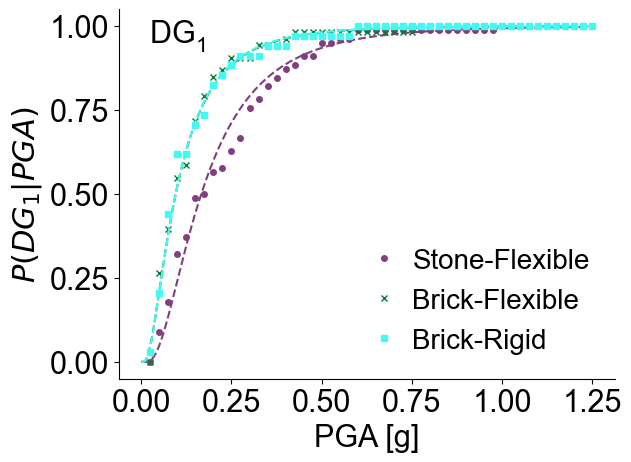

DG2 - theta_Stone-Flexible:  0.32
DG2 - beta_Stone-Flexible:  0.66
 
DG2 - theta_Brick-Flexible:  0.26
DG2 - beta_Brick-Flexible:  0.67
 
DG2 - theta_Brick-Rigid:  0.25
DG2 - beta_Brick-Rigid:  0.7
 


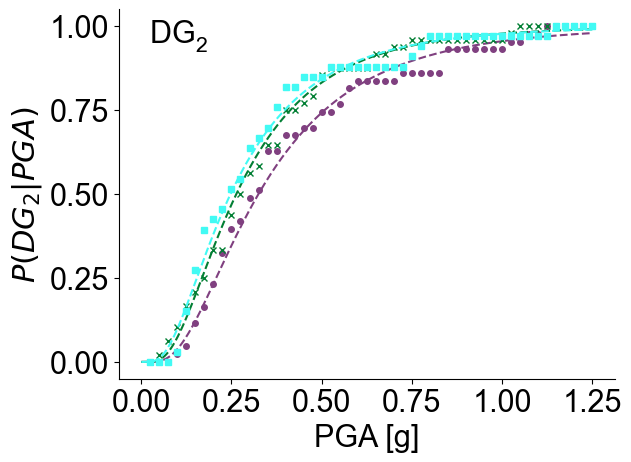

DG3 - theta_Stone-Flexible:  0.41
DG3 - beta_Stone-Flexible:  0.5
 
DG3 - theta_Brick-Flexible:  0.36
DG3 - beta_Brick-Flexible:  0.55
 
DG3 - theta_Brick-Rigid:  0.42
DG3 - beta_Brick-Rigid:  0.66
 


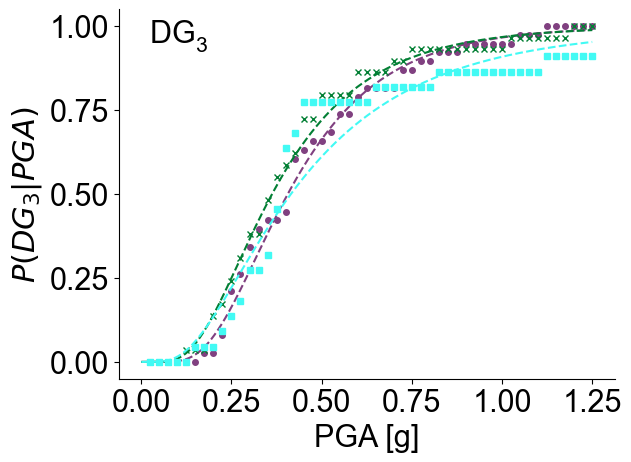

DG4 - theta_Stone-Flexible:  0.51
DG4 - beta_Stone-Flexible:  0.37
 
DG4 - theta_Brick-Flexible:  0.61
DG4 - beta_Brick-Flexible:  0.52
 
DG4 - theta_Brick-Rigid:  0.75
DG4 - beta_Brick-Rigid:  0.46
 


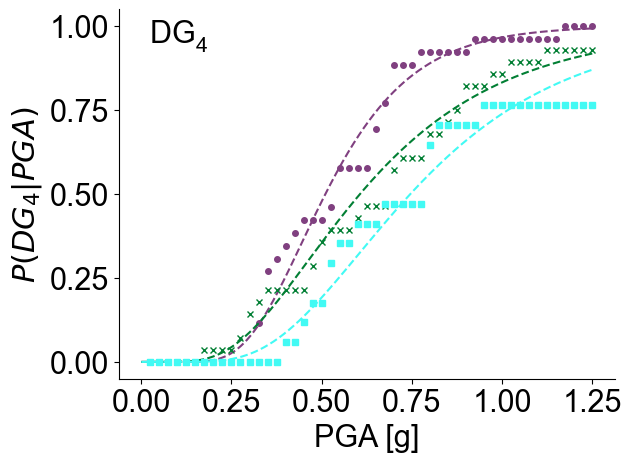

DG5 - theta_Stone-Flexible:  0.64
DG5 - beta_Stone-Flexible:  0.34
 
DG5 - theta_Brick-Flexible:  0.77
DG5 - beta_Brick-Flexible:  0.23
 
DG5 - theta_Brick-Rigid:  0.83
DG5 - beta_Brick-Rigid:  0.27
 


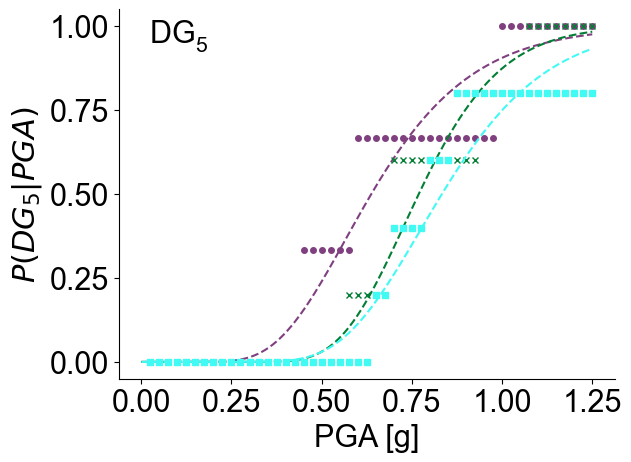

In [207]:
#Building clustering criteria
xp = []
xp_aux = []
xp_comb = []
clust_3 = 'Mat_Diaph';    #clustering based on the material of the masonry and material of diaphragm
clust_select = clust_3

# Clustering 3: For masonry type and type of diaphragm together
if clust_select == clust_3:
    
    # Get info accounting for both masonry material and type of diaphragm
    stone_types = ['calcareous', 'sandstone', 'limestone', 'granite', 'tuff']
    feature = ['Stone', 'Brick'] # features for the selection
    for i, value in enumerate(mat_series):
        if any(stone_type in value.lower() for stone_type in stone_types[:3]):
            xp.append(feature[0])
        elif any(stone_type in value.lower() for stone_type in stone_types[3:]):
            xp.append(feature[0])
        elif 'clay' in value.lower():
            xp.append(feature[1])
        elif 'calcium' in value.lower():
            xp.append(feature[1])  
        elif 'concrete' in value.lower():
            xp.append(feature[1])
        elif 'mortar' in value.lower():
            xp.append(feature[1]) 
        elif 'adobe' in value.lower():
            xp.append(feature[1])
        else:
            xp.append(feature[0])
    
    for i in range(len(xp)):
        xp_aux.append([xp[i], diaph_series[i]])
    
    feature = ['Flexible', 'Rigid', 'No diaph.']
    for i, value in enumerate(xp_aux):
        if value[0] == 'Brick' and value[1] == 'Timber':
            xp_comb.append(f"{value[0]}-{feature[0]}")
        elif value[0] == 'Brick' and value[1] == 'RC':
            xp_comb.append(f"{value[0]}-{feature[1]}")
        elif value[0] == 'Brick' and value[1] == 'Mixed': #this is treated as RC (rigid diaphragm)
            xp_comb.append(f"{value[0]}-{feature[1]}")
        elif value[0] == 'Brick' and value[1] != 'N/A':
            xp_comb.append(f"{value[0]}-{feature[2]}")    
        elif value[0] == 'Stone' and value[1] == 'Timber':
            xp_comb.append(f"{value[0]}-{feature[0]}")
        elif value[0] == 'Stone' and value[1] == 'RC':
            xp_comb.append(f"{value[0]}-{feature[1]}")
        elif value[0] == 'Stone' and value[1] == 'Mixed':
            xp_comb.append(f"{value[0]}-{feature[1]}")
        elif value[0] == 'Stone' and value[1] != 'N/A':
            xp_comb.append(f"{value[0]}-{feature[2]}")
        else:
            xp_comb.append(f"{value[0]}-{feature[2]}")

# Initialize arrays of variables to be saved
feature = ['Stone-Flexible', 'Brick-Flexible', 'Brick-Rigid']
num_features = len(feature)
p_exceed_DG = [[[] for _ in range(num_features)] for _ in range(num_grades)]
count = [[[0 for _ in range(num_PGA_thresh)] for _ in range(num_features)] for _ in range(num_grades)]

# Create a dictionary to store separated arrays
separated_arrays = {}

# Iterate through the data and populate the dictionary
for pgas, dgs, m in zip(pga, dg, xp_comb):
    key = (dgs, m)
    if key not in separated_arrays:
        separated_arrays[key] = []
    separated_arrays[key].append(pgas)
    
# Convert the lists in the dictionary to NumPy arrays
for key in separated_arrays:
    separated_arrays[key] = np.array(separated_arrays[key])

# Create a copy of the array for post-processing DG values
DG = separated_arrays.copy()

#Count values that are below a certain pga value
for i in range(0, num_features): #building without diaphragm are not plotted
    for j in range(0, num_PGA_thresh):
        count[0][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(1,feature[i])])
        count[1][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(2,feature[i])])
        count[2][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(3,feature[i])])
        count[3][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(4,feature[i])])
        count[4][i][j] = sum(np.sum(np.array(subarr) <= PGA_thresh[j]) for subarr in DG[(5,feature[i])])
        
        p_exceed_DG[0][i].append(count[0][i][j] / np.sum(~np.isnan(DG[(1,feature[i])])))
        p_exceed_DG[1][i].append(count[1][i][j] / np.sum(~np.isnan(DG[(2,feature[i])])))
        p_exceed_DG[2][i].append(count[2][i][j] / np.sum(~np.isnan(DG[(3,feature[i])])))
        p_exceed_DG[3][i].append(count[3][i][j] / np.sum(~np.isnan(DG[(4,feature[i])])))
        p_exceed_DG[4][i].append(count[4][i][j] / np.sum(~np.isnan(DG[(5,feature[i])])))

# Maximum log-likelihood estimator to fit lognormal distribution to empirical data
IM = PGA_thresh
theta = np.zeros((num_grades, num_features))
beta = np.zeros((num_grades, num_features))

for i in range(0, num_grades):
    for j in range(0, num_features):
        if ~np.isnan(p_exceed_DG[i][j]).any() and np.count_nonzero(p_exceed_DG[i][j]) != 0 and ~np.isin(p_exceed_DG[i][j], [0, 1]).all():
            _, theta[i][j], beta[i][j] = probit_function(IM, p_exceed_DG[i][j])

# Plot the fragilities
for i in range(0, num_grades):
    for j in range(0, num_features):
        if theta[i][j] != 0:
            print('DG' + str(i+1) + ' - theta_' + str(feature[j]) +  ': ', round(theta[i][j],2))
            print('DG' + str(i+1) + ' - beta_' + str(feature[j]) +  ': ', round(beta[i][j],2))
            print(' ')
            y = lognorm.cdf(x, beta[i][j], scale=theta[i][j])  # Calculate the CDF for each x-value
            
            plt.plot(x, y, '--', color=colors[j+12])
            plt.plot(PGA_thresh, p_exceed_DG[i][j], markers[j], color=colors[j+12], markersize=mk_size, label=feature[j])
    
    plt.text(0.02, 0.95, "$\mathregular{DG_"+ str(i+1)+"}$", fontsize = 22)
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
    plt.xticks([0, 0.25, 0.5, 0.75, 1.0, 1.25])
    if i == 0:
        plt.legend(frameon=False, fontsize=lgd_font, handletextpad=0.01)
    
    plt.rcParams['font.size'] = plt_font
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    plt.xlabel('PGA [g]', fontsize=axisLabel_font)
    plt.ylabel(r"$P(DG_{"+ str(i+1)+"} | PGA)$", fontsize=axisLabel_font)   
    
    plt.show()
